**Problem3: CGAN**

In [ ]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Flatten, Dropout, Reshape, Concatenate
from keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.models import Model
from keras.optimizers import Adam

from keras.datasets import cifar10
import keras.backend as K

import matplotlib.pyplot as plt

import sys
import numpy as np

BATCH_SIZE = 16

%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Load Necessary libraries**

In [ ]:
def load_data():
    # # Get training images
    (X_train, y_train), (X_test, _) = cifar10.load_data()
    X_train = X_train[:25000]
    y_train = y_train[:25000]

# Normalize data
    X_train = (X_train - 127.5) / 127.5

# 1hot encode labels
    y_train = one_hot_encode(y_train[:,0])
    return X_train, y_train


**Load and Preprocess the data**

In [ ]:
def get_generator(input_layer, condition_layer):

  merged_input = Concatenate()([input_layer, condition_layer])
  
  hid = Dense(128 * 8 * 8, activation='relu')(merged_input)    
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)
  hid = Reshape((8, 8, 128))(hid)

  hid = Conv2D(128, kernel_size=4, strides=1,padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)    
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1,padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)    
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)                      
  hid = Conv2D(3, kernel_size=5, strides=1, padding="same")(hid)
  out = Activation("tanh")(hid)

  model = Model(inputs=[input_layer, condition_layer], outputs=out)
  model.summary()
  
  return model, out

**Define Genrator part: This part is Generator. In this part we used CNN and Tranpose-CNN to make an image from a gausian, 100 dimension white noise and conditional label input. Some one can find full description of this architecutre in the Report of this Mini-Project**

In [ ]:
def get_discriminator(input_layer, condition_layer):
  hid = Conv2D(128, kernel_size=3, strides=1, padding='same')(input_layer)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
  hid = BatchNormalization(momentum=0.9)(hid)
  hid = LeakyReLU(alpha=0.1)(hid)

  hid = Flatten()(hid)
  
  merged_layer = Concatenate()([hid, condition_layer])
  hid = Dense(512, activation='relu')(merged_layer)
  #hid = Dropout(0.4)(hid)
  out = Dense(1, activation='sigmoid')(hid)

  model = Model(inputs=[input_layer, condition_layer], outputs=out)

  model.summary()

  return model, out

**Define Dsicriminator: This part is Dicdriminator. We used CNN layers to extract the main feautres of image**

In [ ]:
def gan_model(gen_condition_input, disc_condition_input ):
    gan_input = Input(shape=(100,))
    x = generator([gan_input, gen_condition_input])
    gan_out = discriminator([x, disc_condition_input])
    gan = Model(inputs=[gan_input, gen_condition_input, disc_condition_input], outputs=gan_out)
    gan.summary()
    return gan

**GAN Model: By mergin Discriminator and Generator we made our C-GAN**

In [ ]:
from keras.preprocessing import image

def one_hot_encode(y):
  z = np.zeros((len(y), 10))
  idx = np.arange(len(y))
  z[idx, y] = 1
  return z

def generate_noise(n_samples, noise_dim):
  X = np.random.normal(0, 1, size=(n_samples, noise_dim))
  return X

def generate_random_labels(n):
  y = np.random.choice(10, n)
  y = one_hot_encode(y)
  return y
tags = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
def show_samples(epoch):
  fig, axs = plt.subplots(10, 10, figsize=(15,15))
  plt.subplots_adjust(hspace=0.0, wspace=0.0)
  NUMBER_PER_CLASS = 10
  for classlabel in range(10):
    row = int(classlabel / 2)
    coloffset = (classlabel % 2) * 3
    lbls = one_hot_encode([classlabel] * NUMBER_PER_CLASS)
    noise = generate_noise(NUMBER_PER_CLASS, 100)
    gen_imgs = generator.predict([noise, lbls])

    for i in range(NUMBER_PER_CLASS):
        # Dont scale the images back, let keras handle it
        img = image.array_to_img(gen_imgs[i], scale=True)
        axs[i,classlabel].imshow(img)
        axs[i,classlabel].axis('off')
  fig.savefig('/content/drive/My Drive/NeuralNet/Q3/CGAN_FINAL/Epoch_%d.png' % epoch, bbox_inches='tight')
  plt.close()

**Some useful functions for generating noise, random labels and showing samples and also make one-hot encoded label**

In [ ]:
def plot_diagram(g_loss,d_loss, epoch):

  plt.figure(figsize=(15, 6))
  plt.plot(list(range(1, epoch + 2)),g_loss, linewidth=3)
  plt.plot(list(range(1, epoch + 2)),d_loss, linewidth=3)
  plt.legend(['generator','discriminator'])

  plt.title("Loss Values")
  plt.ylabel("Loss")
  plt.xticks(list(range(1, epoch + 1)))
  plt.xlabel('epoch')
  plt.grid(which='both', axis='both')
  plt.show()


**plot Loss function Diagram**

In [ ]:
# GAN creation
img_input = Input(shape=(32,32,3))
disc_condition_input = Input(shape=(10,))

discriminator, disc_out = get_discriminator(img_input, disc_condition_input)
discriminator.compile(optimizer=Adam(0.001, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False

noise_input = Input(shape=(100,))
gen_condition_input = Input(shape=(10,))
generator, gen_out = get_generator(noise_input, gen_condition_input)

gan = gan_model(gen_condition_input, disc_condition_input )


gan.compile(optimizer=Adam(0.001, 0.5), loss='binary_crossentropy')

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 32, 32, 128)  3584        input_40[0][0]                   
__________________________________________________________________________________________________
batch_normalization_81 (BatchNo (None, 32, 32, 128)  512         conv2d_65[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_81 (LeakyReLU)      (None, 32, 32, 128)  0           batch_normalization_81[0][0]     
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("mo...)`
  """


In [ ]:
X_train, y_train = load_data()
num_batches = int(X_train.shape[0]/BATCH_SIZE)



/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


	Epoch: 1, Generator Loss: 1.6042038649654495, Discriminator Loss: 0.394379599909471


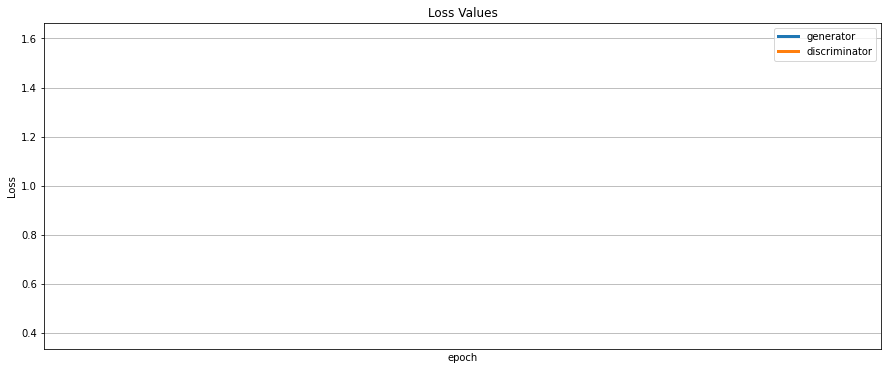

	Epoch: 2, Generator Loss: 1.753345540787896, Discriminator Loss: 0.4053707342599632


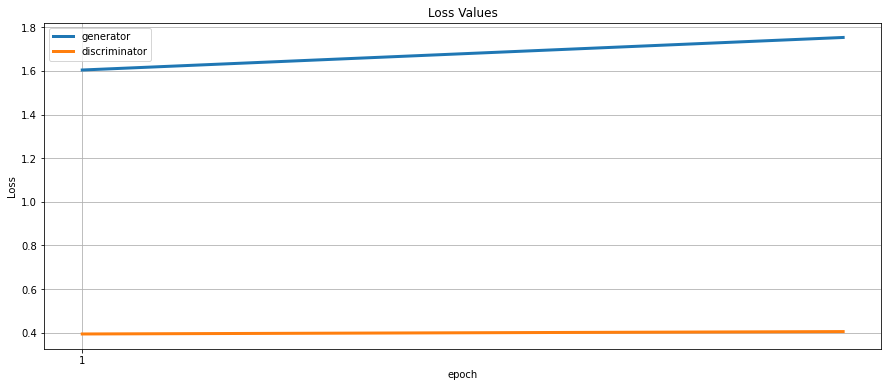

	Epoch: 3, Generator Loss: 1.7865828084693829, Discriminator Loss: 0.4156260862851112


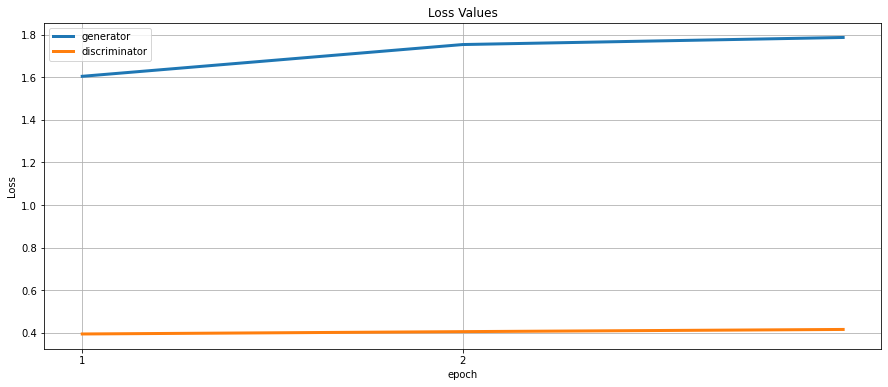

	Epoch: 4, Generator Loss: 1.6572260594856418, Discriminator Loss: 0.4592397301511484


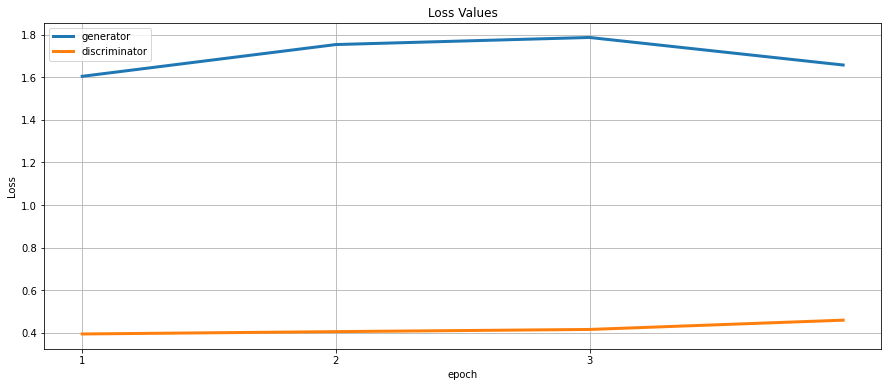

	Epoch: 5, Generator Loss: 1.6770059983037346, Discriminator Loss: 0.4580019512493998


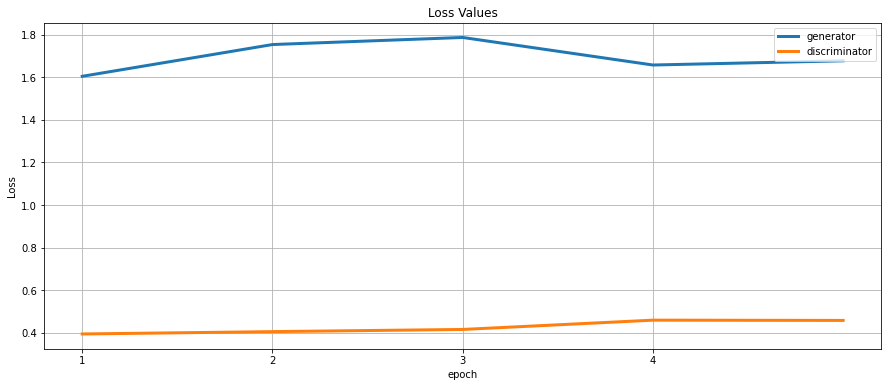

	Epoch: 6, Generator Loss: 1.8472474481094814, Discriminator Loss: 0.4334199443822023


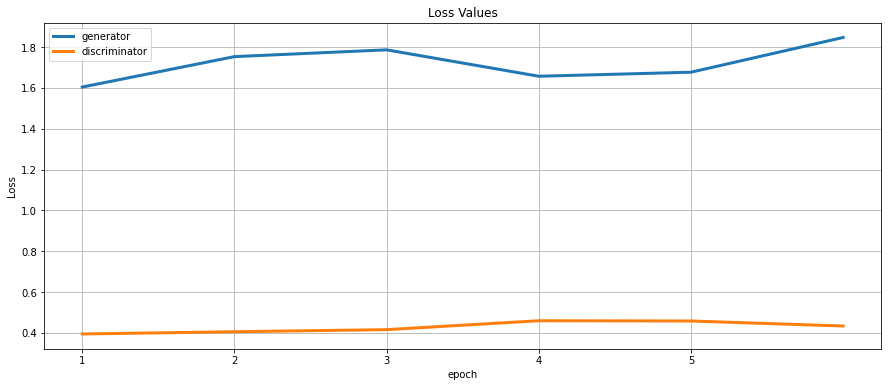

	Epoch: 7, Generator Loss: 1.834145838258819, Discriminator Loss: 0.44456288512323944


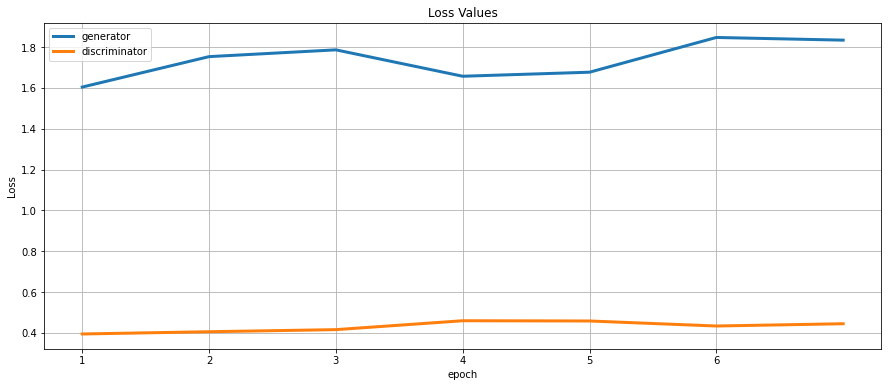

	Epoch: 8, Generator Loss: 1.8987066925487812, Discriminator Loss: 0.4421669231028929


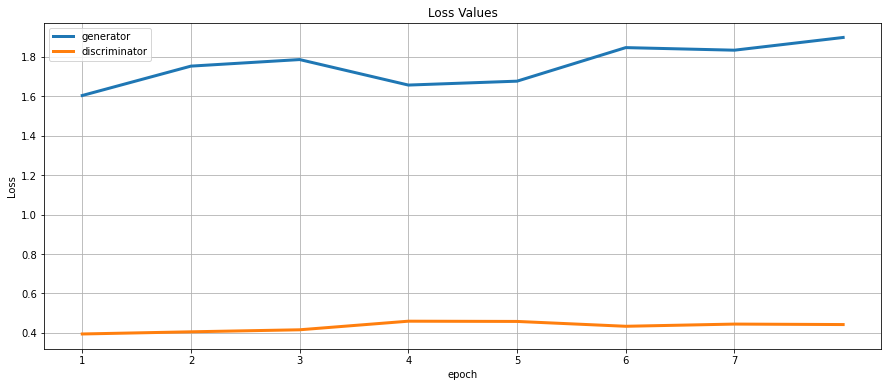

	Epoch: 9, Generator Loss: 2.0253527691055964, Discriminator Loss: 0.4199059714733715


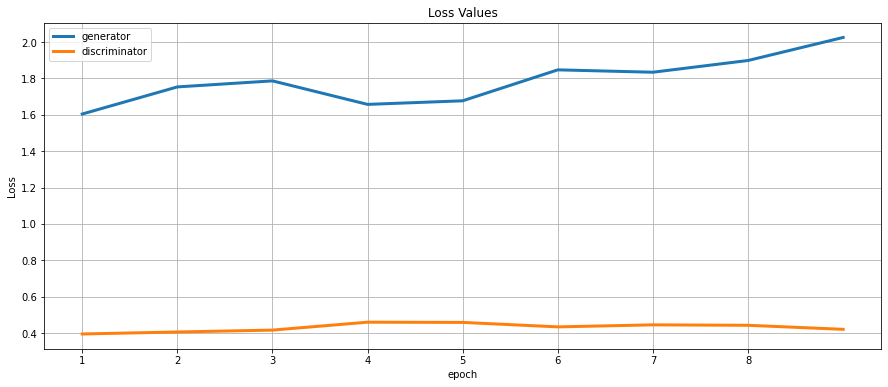

	Epoch: 10, Generator Loss: 2.0872304479421024, Discriminator Loss: 0.41180380846871


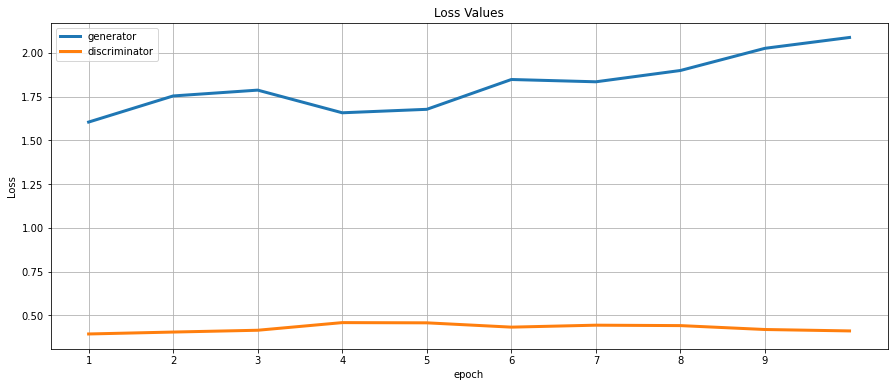

	Epoch: 11, Generator Loss: 2.0721706985740442, Discriminator Loss: 0.4099942059584067


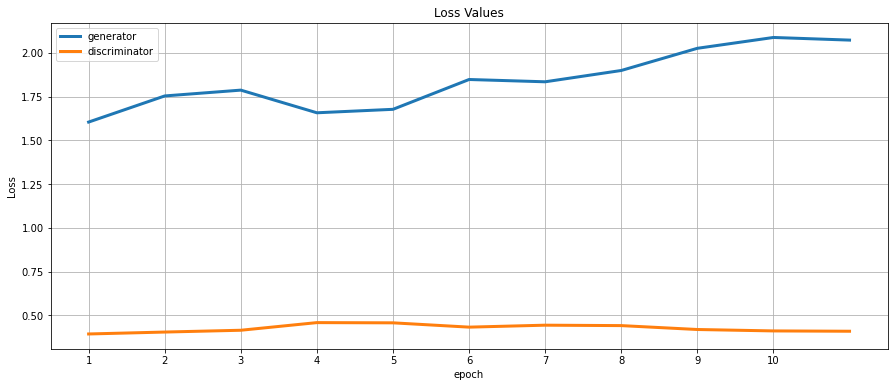

	Epoch: 12, Generator Loss: 2.144738294174668, Discriminator Loss: 0.403748027493798


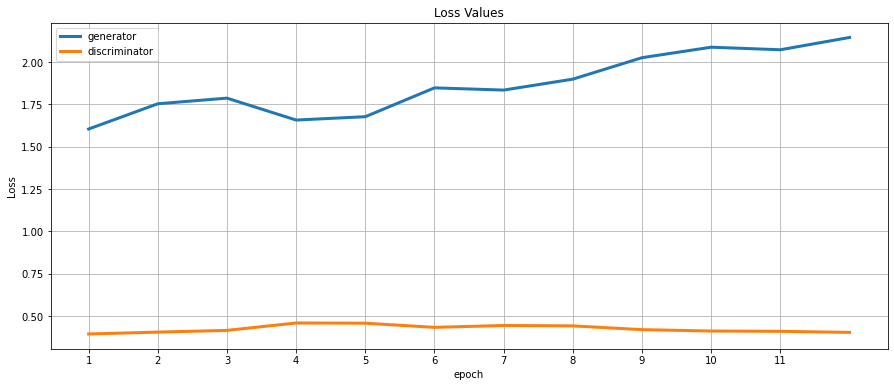

	Epoch: 13, Generator Loss: 2.271580723733206, Discriminator Loss: 0.38539567036451666


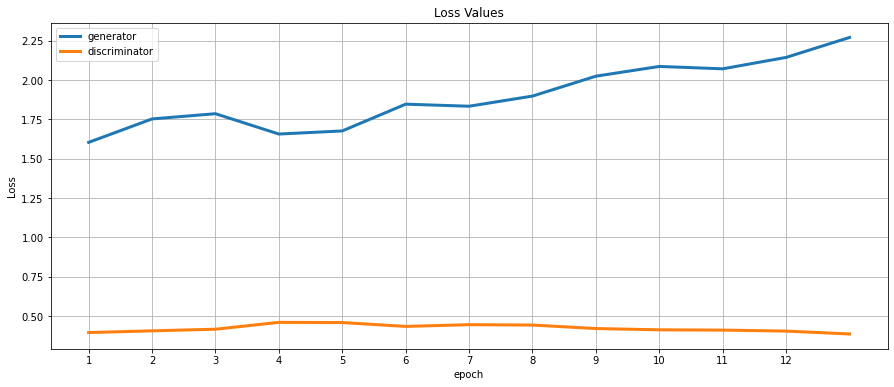

	Epoch: 14, Generator Loss: 2.2658936301587334, Discriminator Loss: 0.3814276037081866


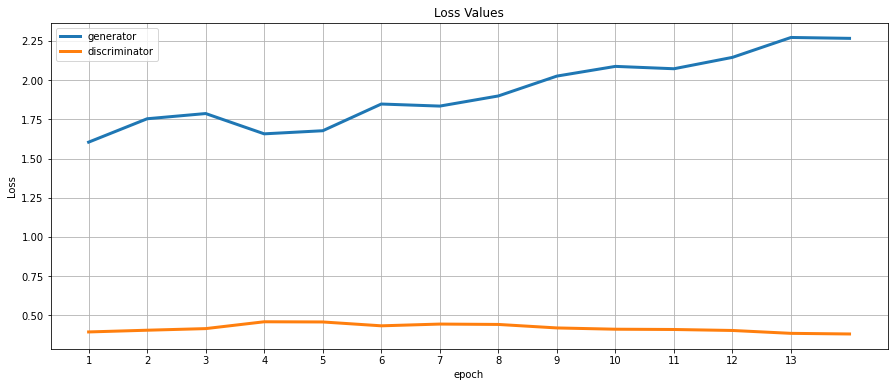

	Epoch: 15, Generator Loss: 2.3262010228160706, Discriminator Loss: 0.37600876030329705


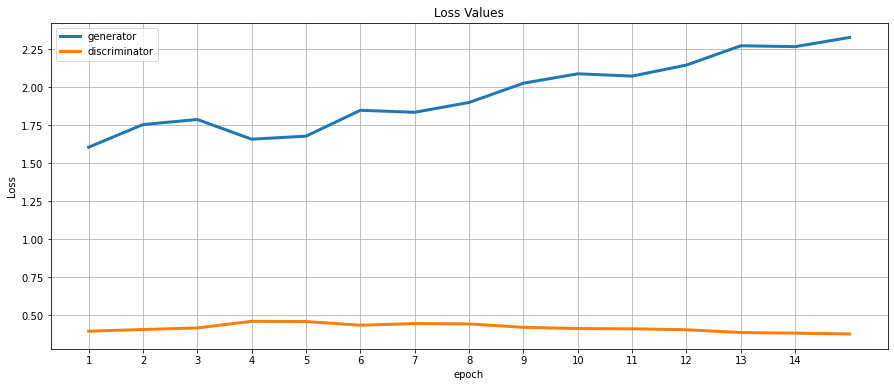

	Epoch: 16, Generator Loss: 2.4223567338591194, Discriminator Loss: 0.36160766757862517


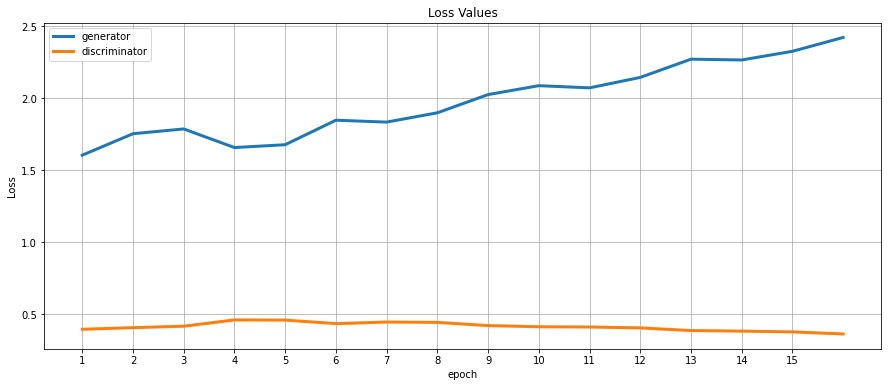

	Epoch: 17, Generator Loss: 2.455057460790865, Discriminator Loss: 0.3534699463203225


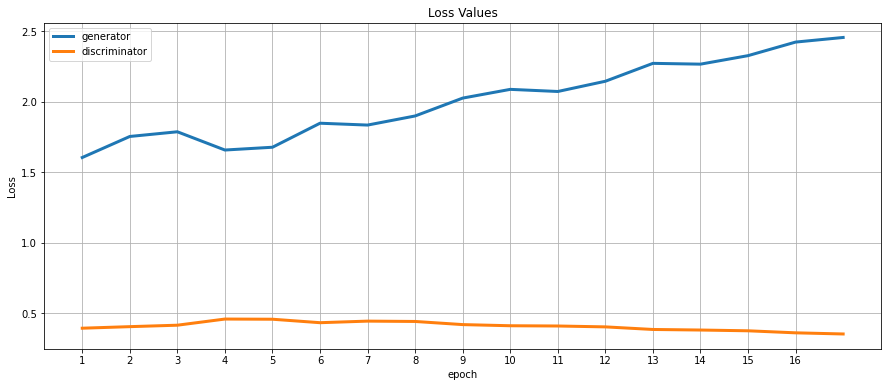

	Epoch: 18, Generator Loss: 2.5418523891558262, Discriminator Loss: 0.3450263850057018


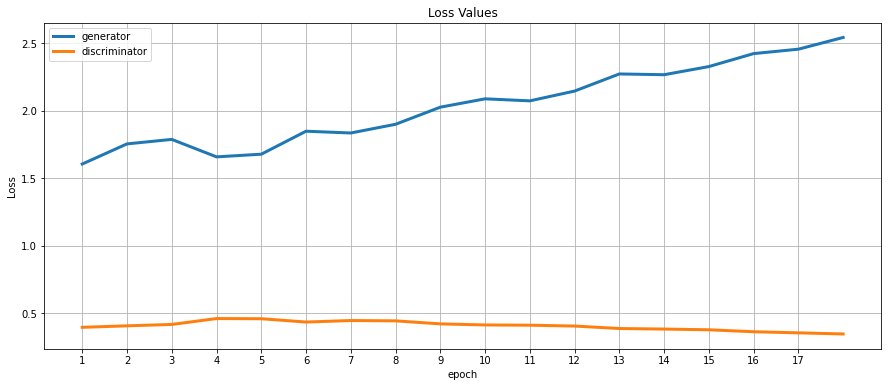

	Epoch: 19, Generator Loss: 2.5652560475693775, Discriminator Loss: 0.3404917698663572


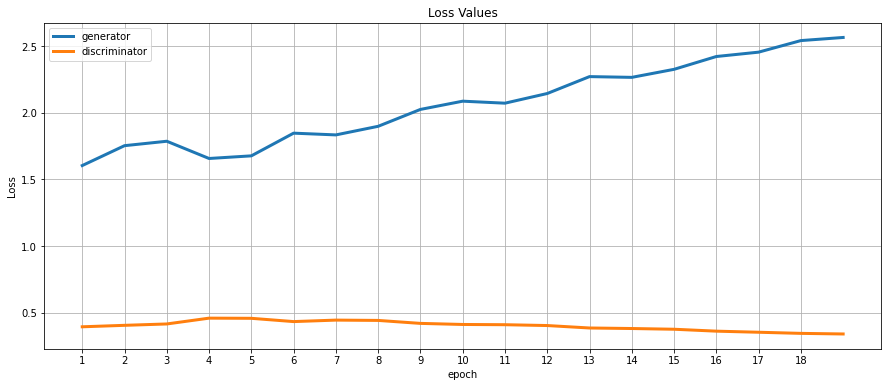

	Epoch: 20, Generator Loss: 2.6020230393327304, Discriminator Loss: 0.33068187288682377


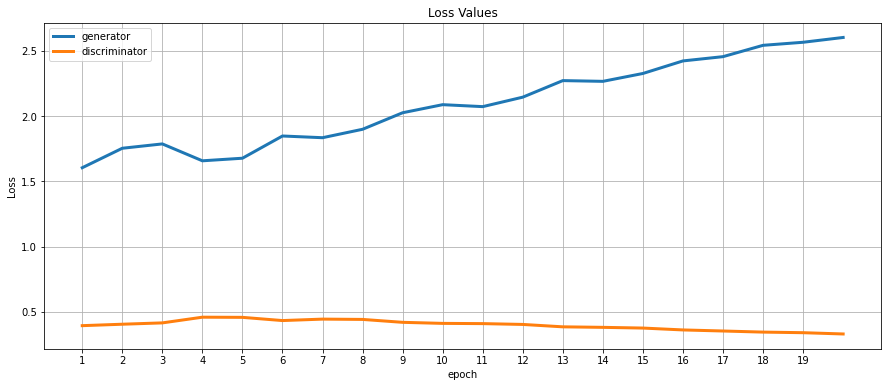

	Epoch: 21, Generator Loss: 2.628833096669975, Discriminator Loss: 0.32596645770396526


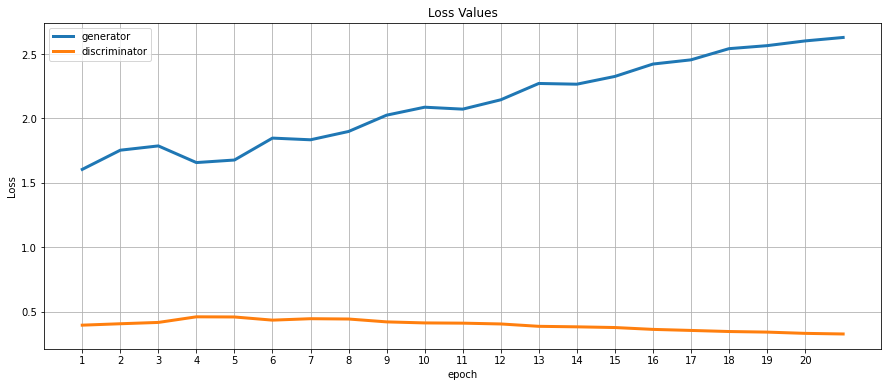

	Epoch: 22, Generator Loss: 2.691705841375527, Discriminator Loss: 0.32198410913367276


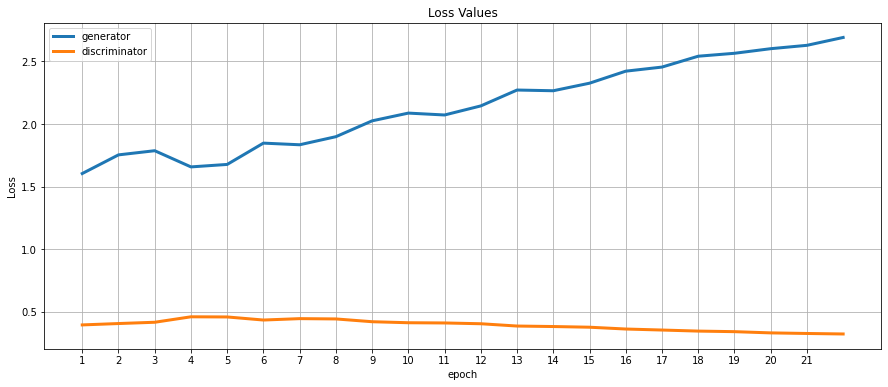

	Epoch: 23, Generator Loss: 2.6593347863793833, Discriminator Loss: 0.3152102618150308


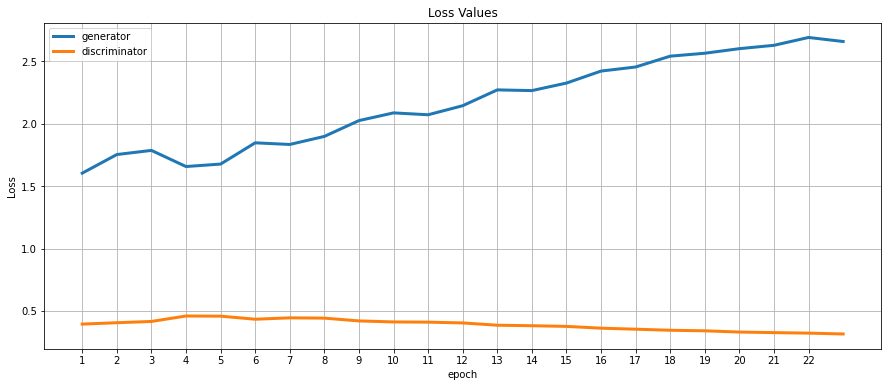

	Epoch: 24, Generator Loss: 2.7269667736165197, Discriminator Loss: 0.3061353070482554


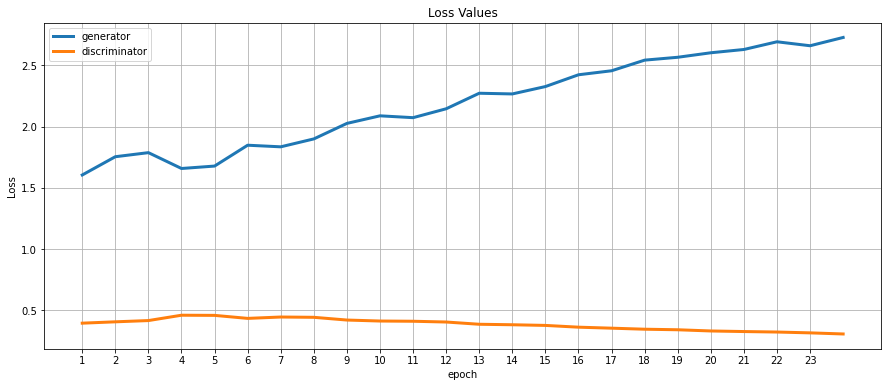

	Epoch: 25, Generator Loss: 2.7204530621841836, Discriminator Loss: 0.303497373065631


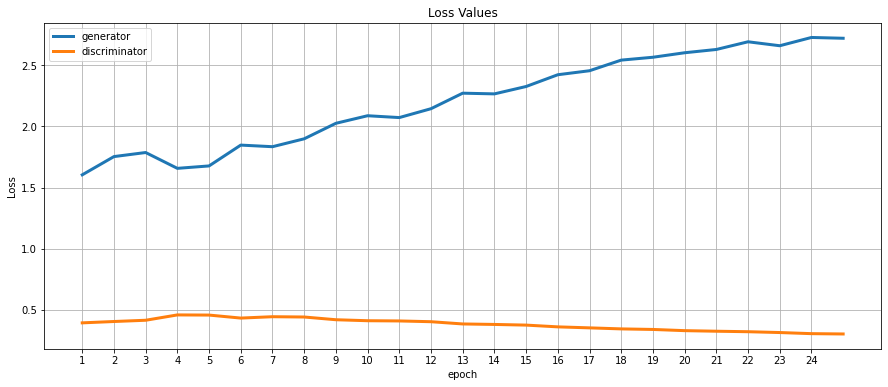

	Epoch: 26, Generator Loss: 2.7395798270894685, Discriminator Loss: 0.3012652720745639


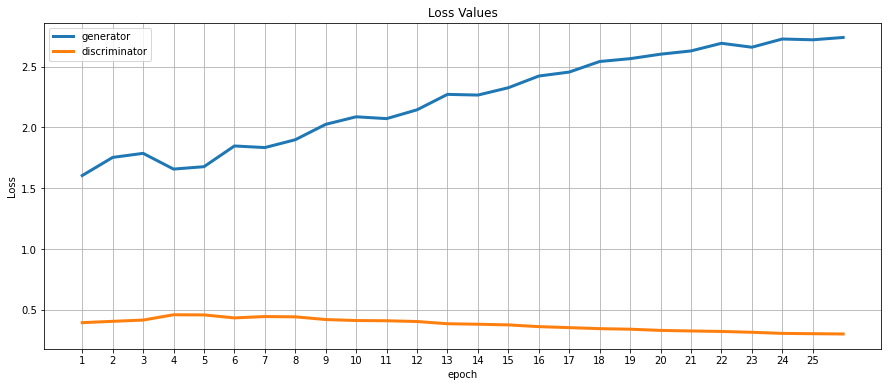

	Epoch: 27, Generator Loss: 2.754462158786808, Discriminator Loss: 0.29667628406715146


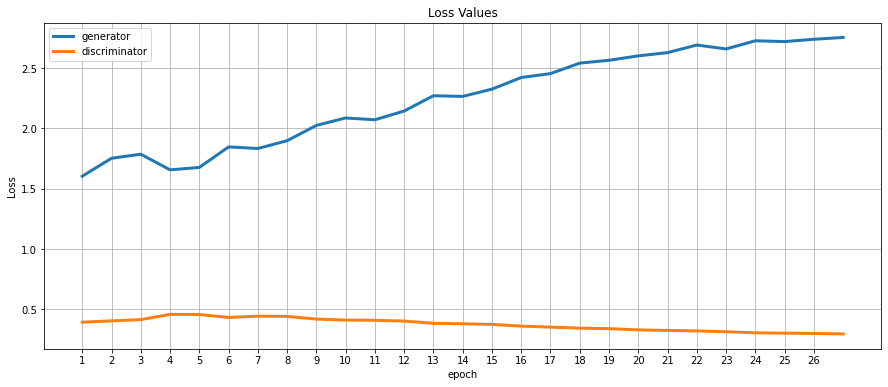

	Epoch: 28, Generator Loss: 2.8046939190233866, Discriminator Loss: 0.2953241717036952


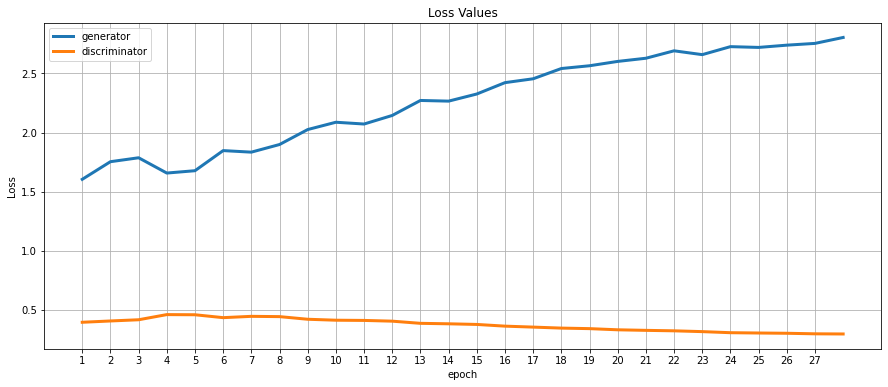

	Epoch: 29, Generator Loss: 2.839800401129277, Discriminator Loss: 0.28190112632917536


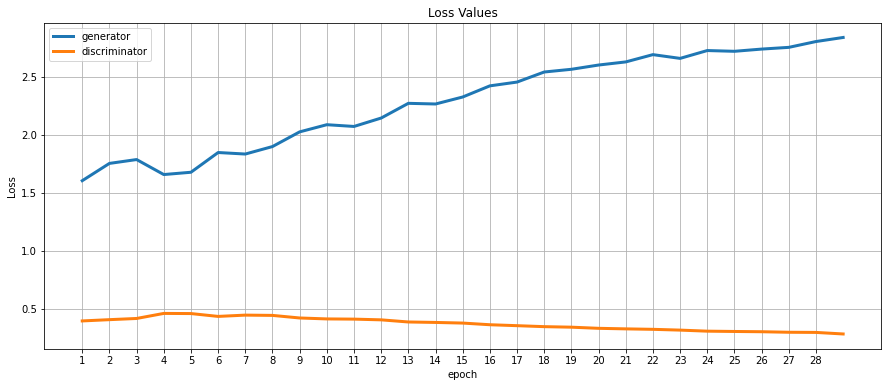

	Epoch: 30, Generator Loss: 2.812137734951039, Discriminator Loss: 0.2911921854055798


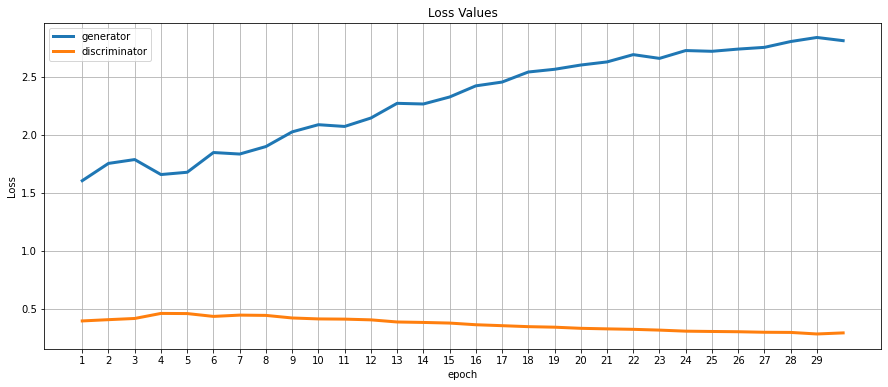

	Epoch: 31, Generator Loss: 2.8207543262598915, Discriminator Loss: 0.28358357877645846


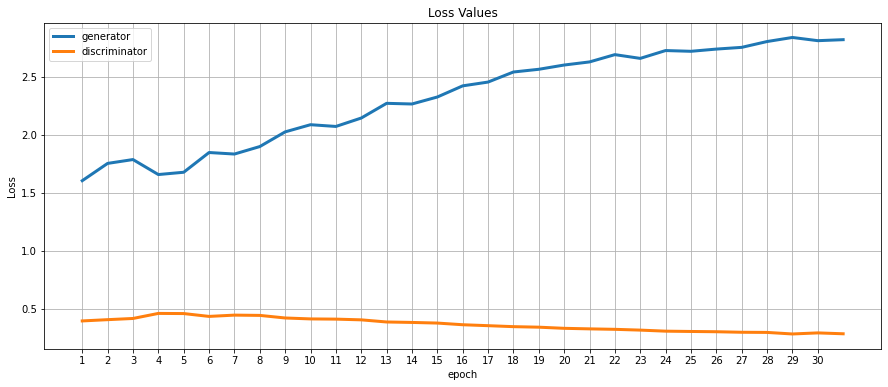

	Epoch: 32, Generator Loss: 2.8357544453974417, Discriminator Loss: 0.2799928985087728


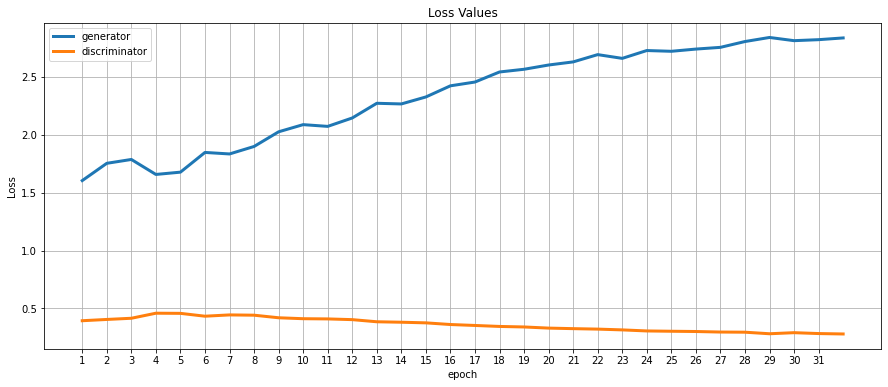

	Epoch: 33, Generator Loss: 2.8635349725104784, Discriminator Loss: 0.28124202869918374


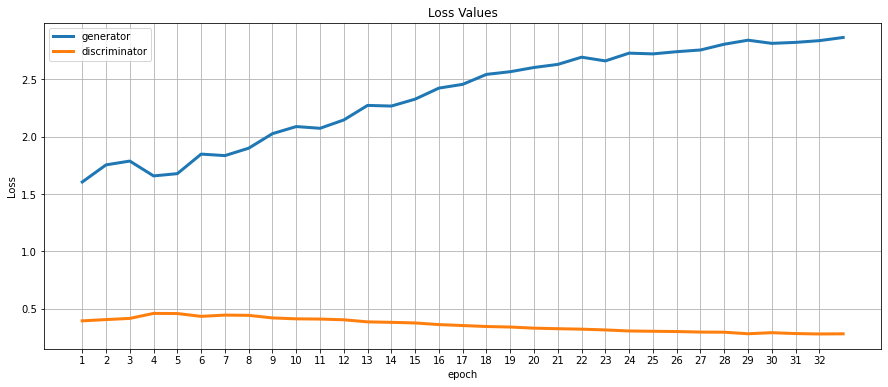

	Epoch: 34, Generator Loss: 2.869513065271585, Discriminator Loss: 0.2758135728433099


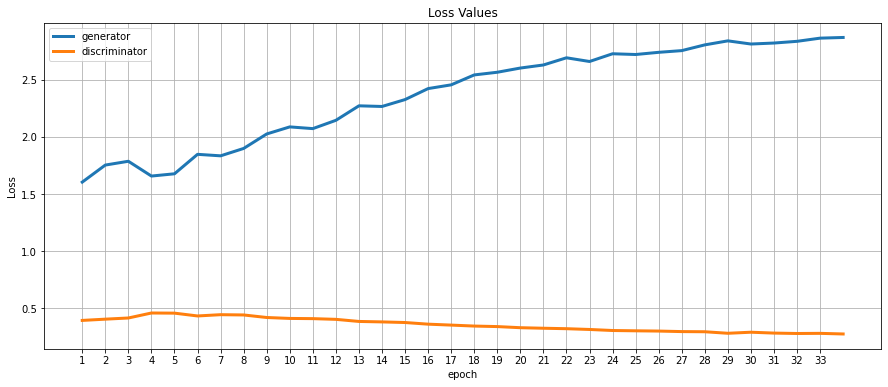

	Epoch: 35, Generator Loss: 2.843465258843157, Discriminator Loss: 0.27439800267335546


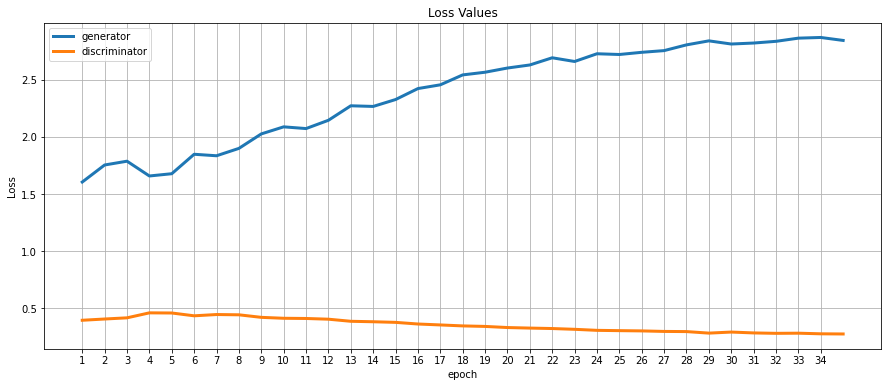

	Epoch: 36, Generator Loss: 2.86087051675048, Discriminator Loss: 0.27362224661891804


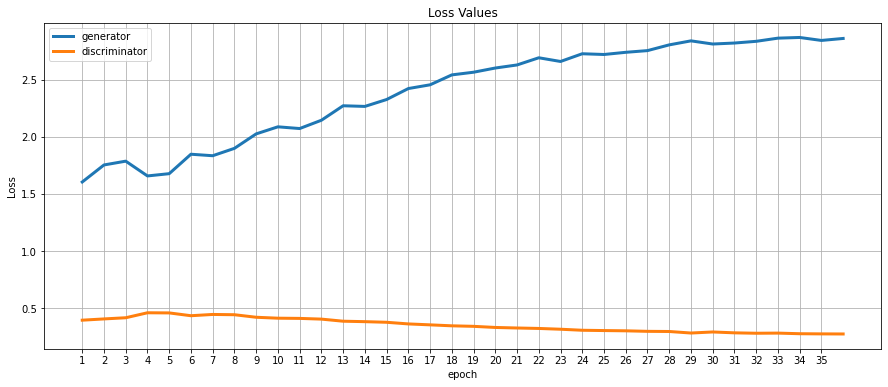

	Epoch: 37, Generator Loss: 2.8202424572158256, Discriminator Loss: 0.2739199590744038


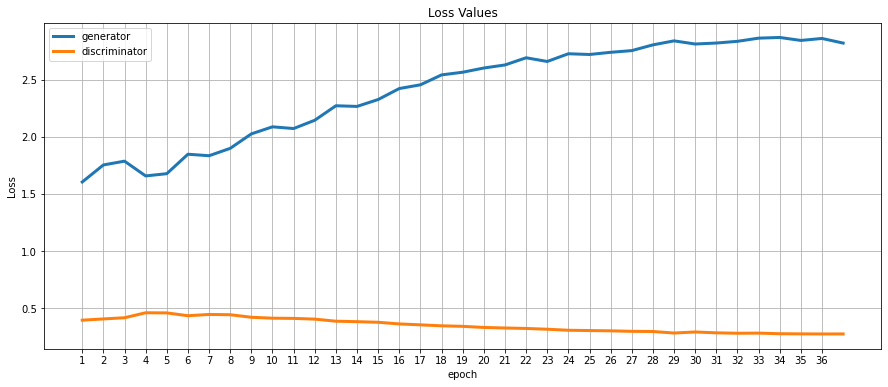

	Epoch: 38, Generator Loss: 2.885298258936207, Discriminator Loss: 0.26581851895731634


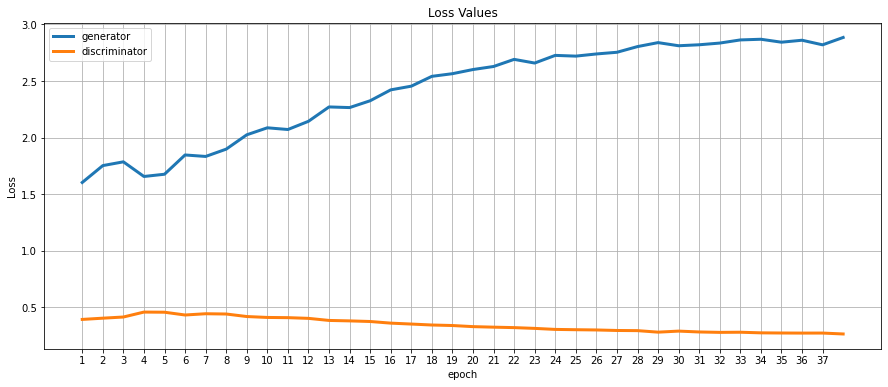

	Epoch: 39, Generator Loss: 2.878212666542063, Discriminator Loss: 0.2653999865894586


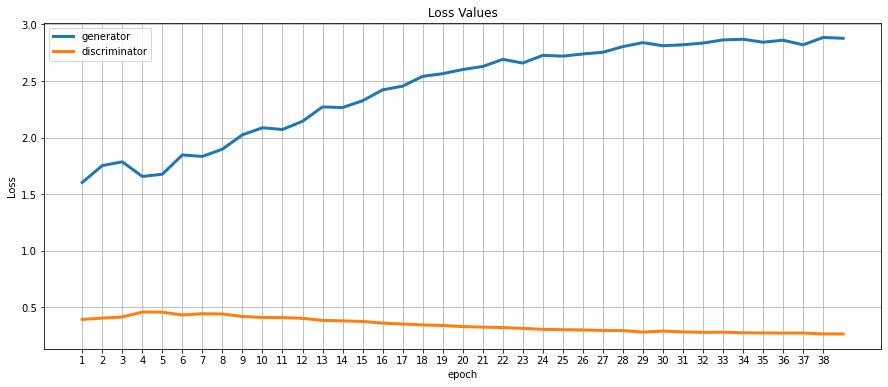

	Epoch: 40, Generator Loss: 2.889170853948166, Discriminator Loss: 0.2635562911381642


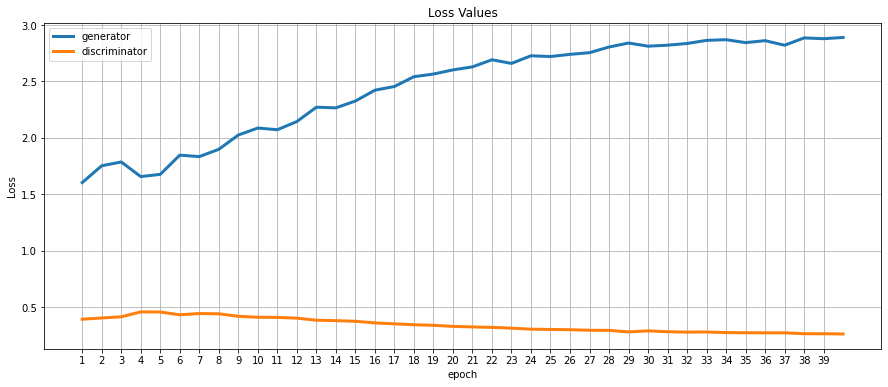

	Epoch: 41, Generator Loss: 2.9099578339220162, Discriminator Loss: 0.2657078194709807


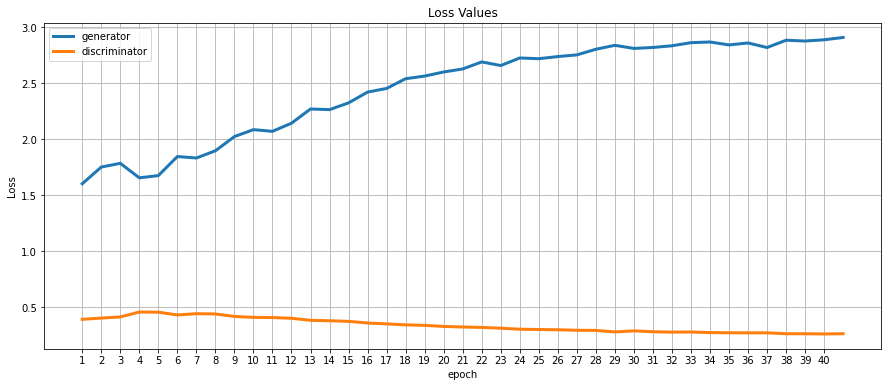

	Epoch: 42, Generator Loss: 2.8972677508328544, Discriminator Loss: 0.25901948779859557


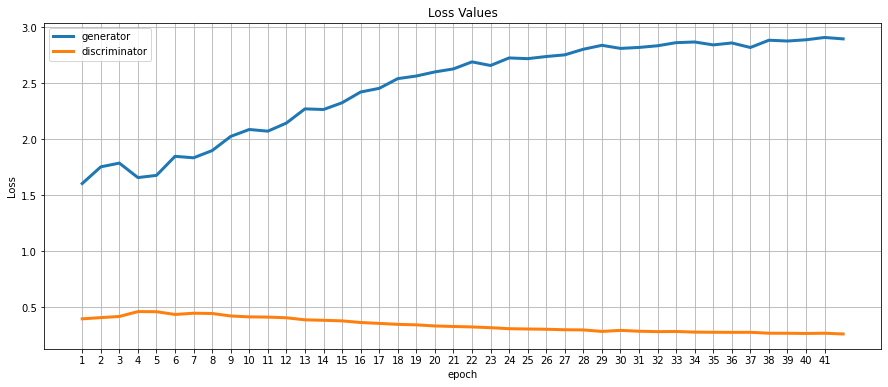

	Epoch: 43, Generator Loss: 2.905178399229477, Discriminator Loss: 0.25877818011138565


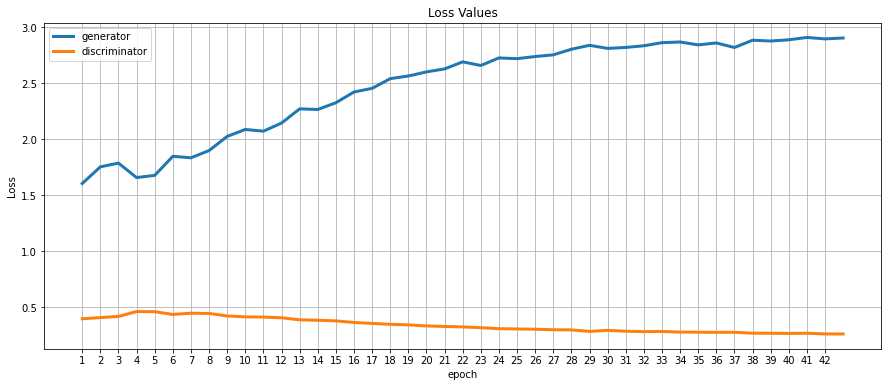

	Epoch: 44, Generator Loss: 2.898202799041201, Discriminator Loss: 0.2587948846755962


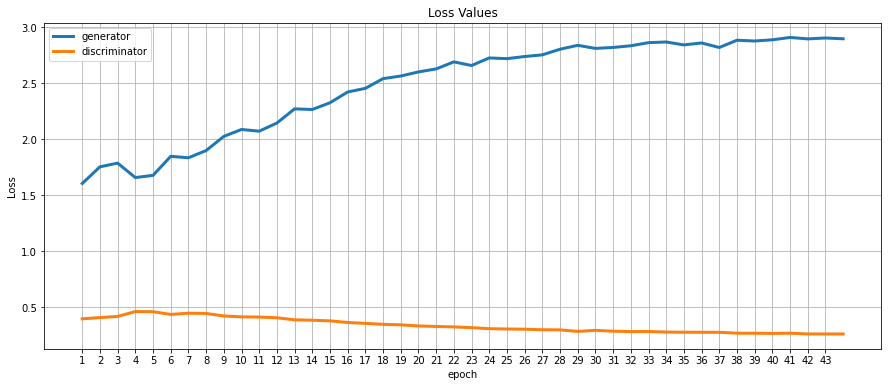

	Epoch: 45, Generator Loss: 2.895373760585443, Discriminator Loss: 0.25872163858059577


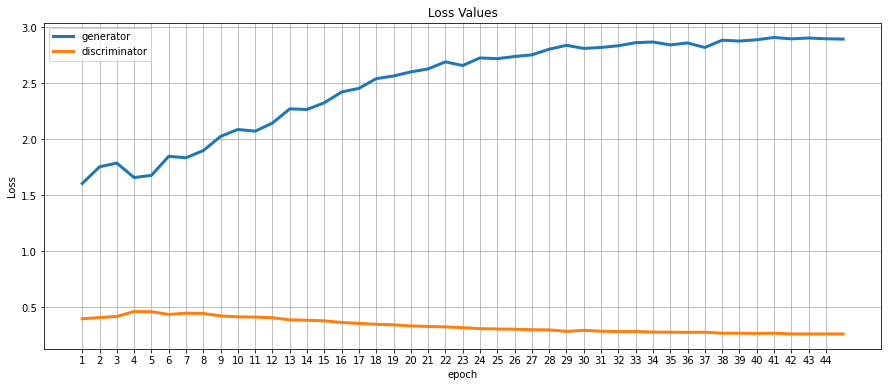

	Epoch: 46, Generator Loss: 2.910018485349516, Discriminator Loss: 0.25767016929792536


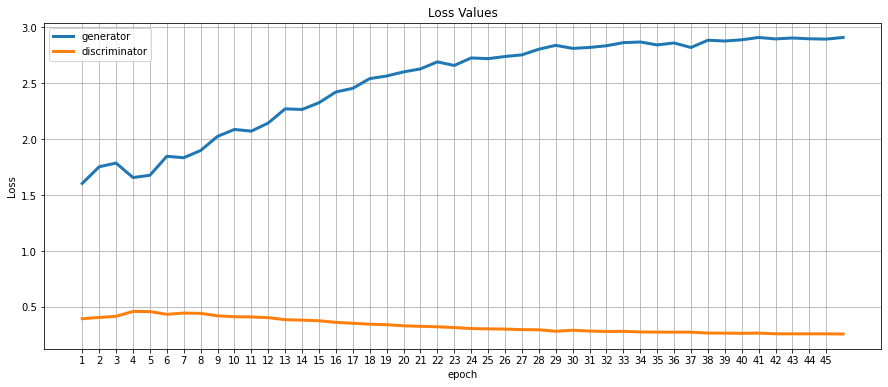

	Epoch: 47, Generator Loss: 2.898588445290408, Discriminator Loss: 0.25453059041393244


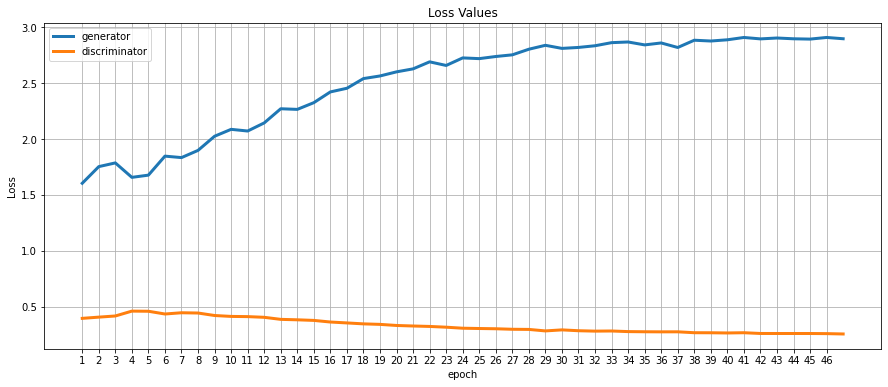

	Epoch: 48, Generator Loss: 2.911874392388267, Discriminator Loss: 0.25512882872519205


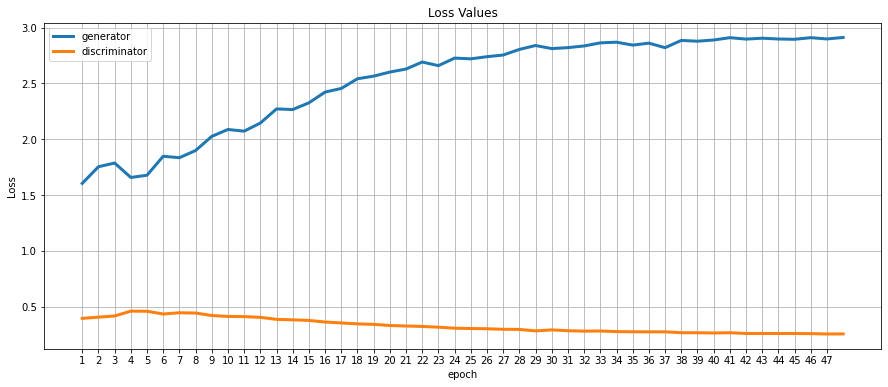

	Epoch: 49, Generator Loss: 2.915883665658753, Discriminator Loss: 0.25222405154024286


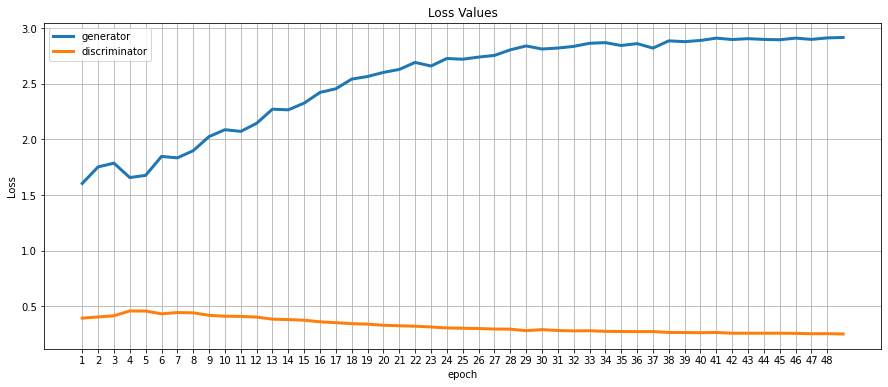

	Epoch: 50, Generator Loss: 2.947931920558634, Discriminator Loss: 0.25200597394291174


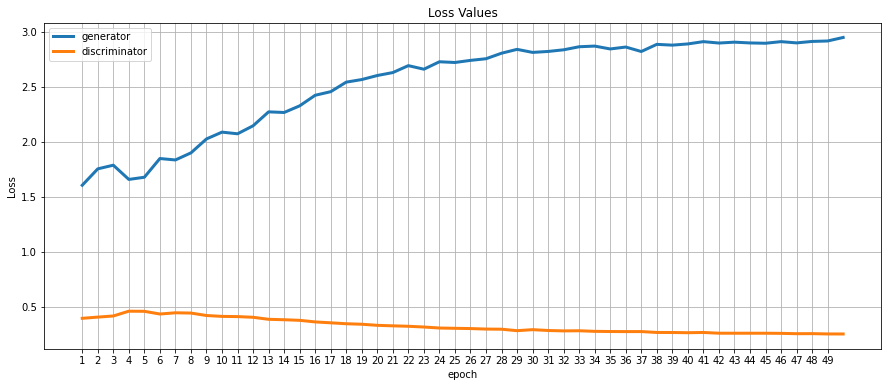

	Epoch: 51, Generator Loss: 2.923409938239868, Discriminator Loss: 0.2515592880346711


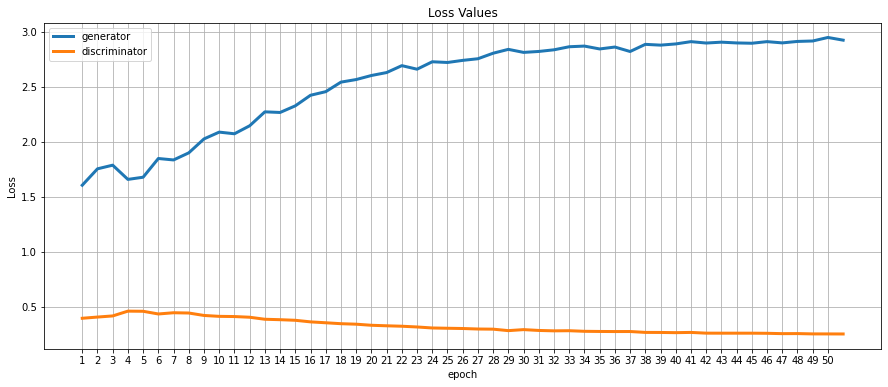

	Epoch: 52, Generator Loss: 2.9279549749956852, Discriminator Loss: 0.24774816613191222


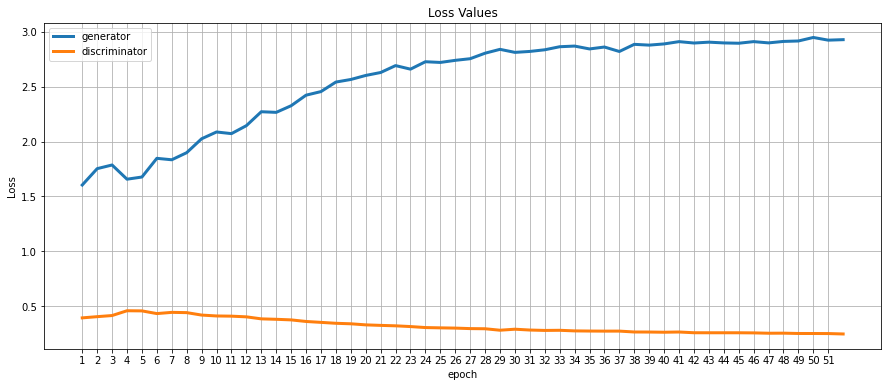

	Epoch: 53, Generator Loss: 2.916250543389827, Discriminator Loss: 0.24897121375715228


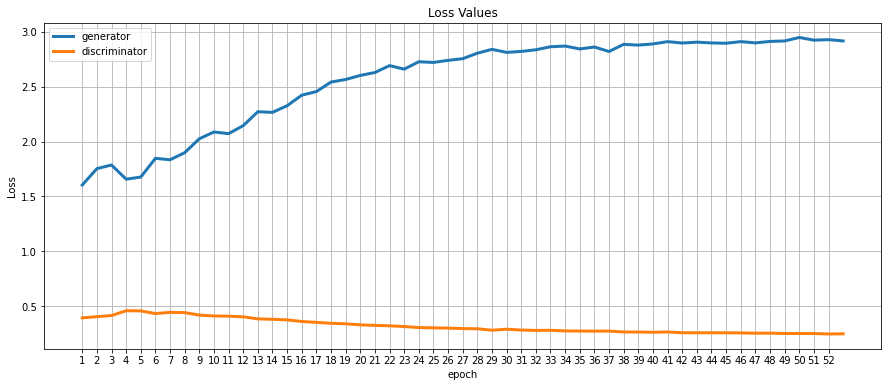

	Epoch: 54, Generator Loss: 2.9481480146034427, Discriminator Loss: 0.24565095205465748


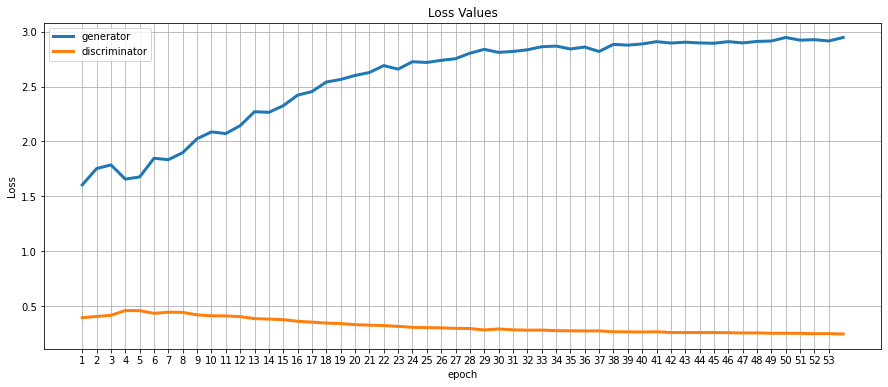

	Epoch: 55, Generator Loss: 2.956613612999226, Discriminator Loss: 0.24576829429167332


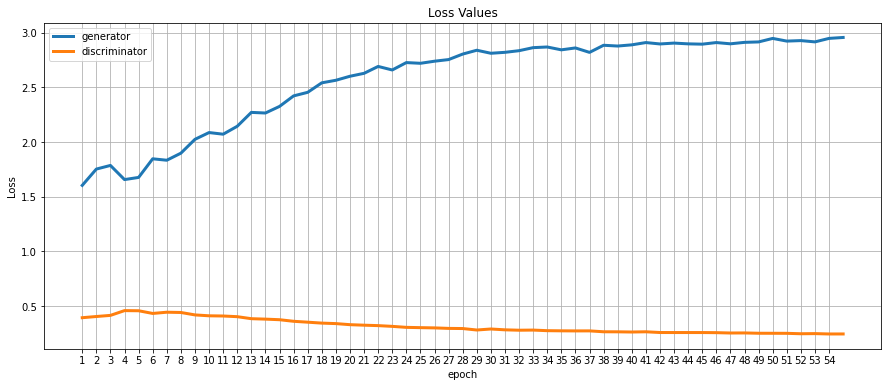

	Epoch: 56, Generator Loss: 2.893731932595811, Discriminator Loss: 0.24740516574678897


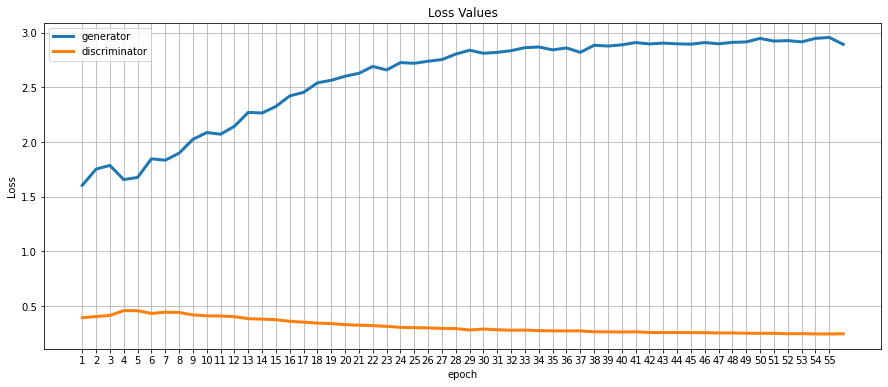

	Epoch: 57, Generator Loss: 2.9567238262230853, Discriminator Loss: 0.2448977032025248


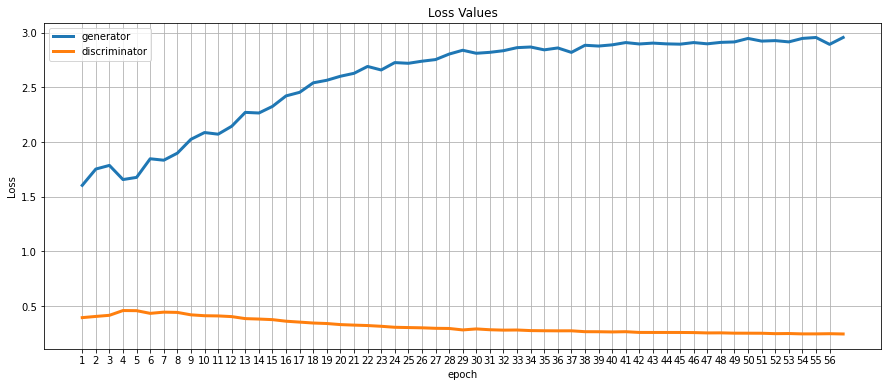

	Epoch: 58, Generator Loss: 2.9421816234704625, Discriminator Loss: 0.24402093826274407


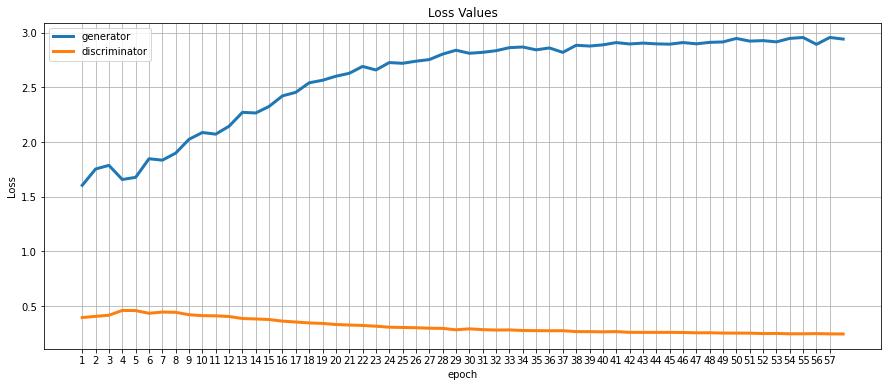

	Epoch: 59, Generator Loss: 2.9236618658568276, Discriminator Loss: 0.24133490295019405


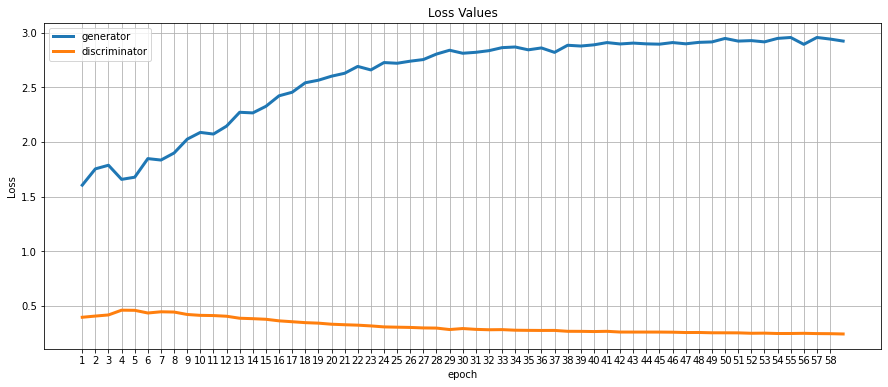

	Epoch: 60, Generator Loss: 2.9501420248409547, Discriminator Loss: 0.24381851020451545


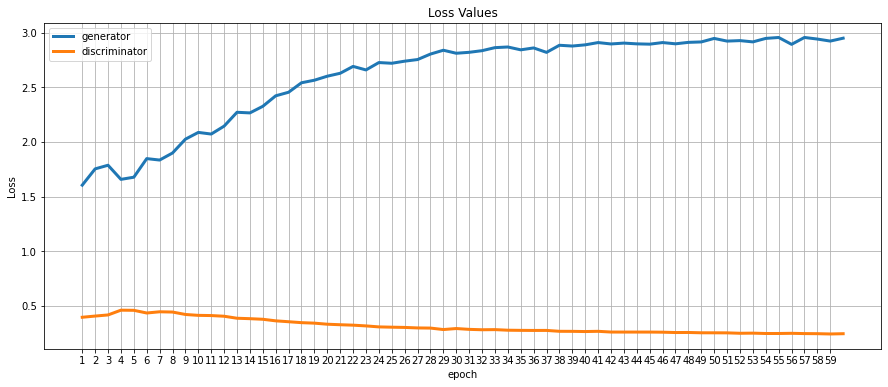

	Epoch: 61, Generator Loss: 2.966894110399996, Discriminator Loss: 0.23866580665187861


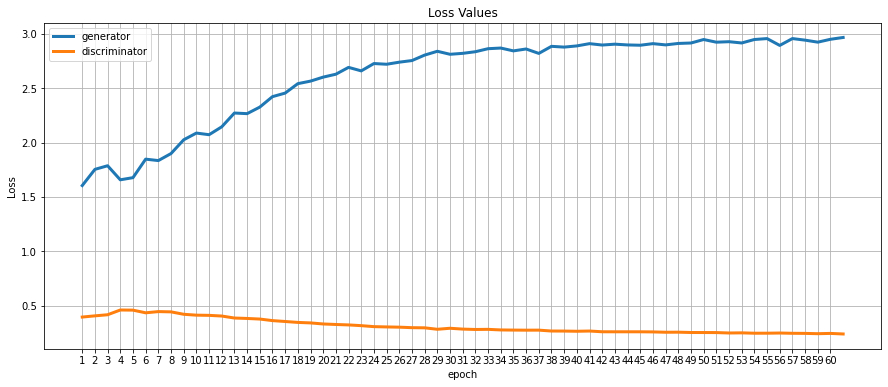

	Epoch: 62, Generator Loss: 2.9335789014984797, Discriminator Loss: 0.23981478760703426


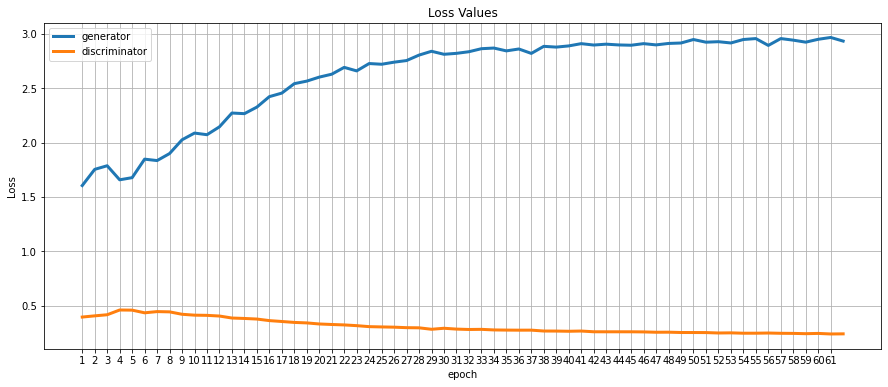

	Epoch: 63, Generator Loss: 2.9524915812873354, Discriminator Loss: 0.23869177199203745


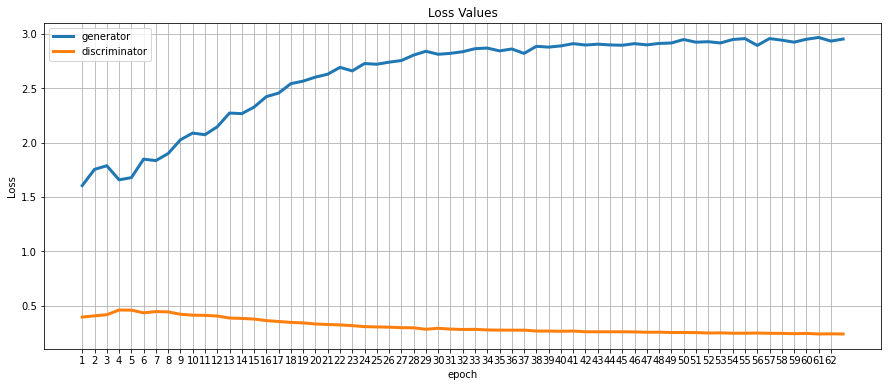

	Epoch: 64, Generator Loss: 2.956787583464697, Discriminator Loss: 0.2387152365319402


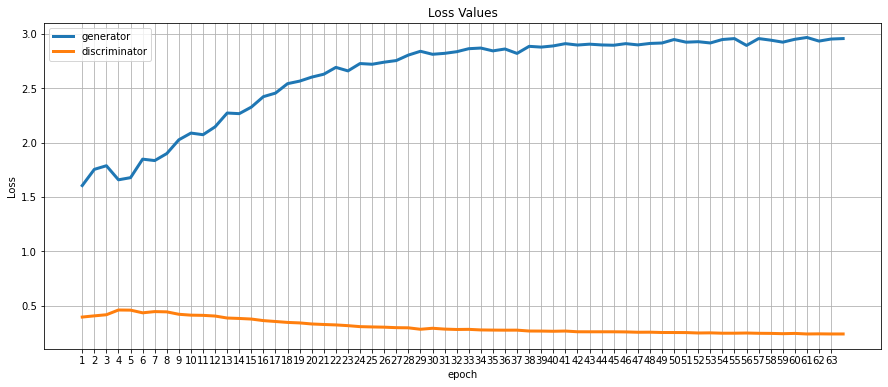

	Epoch: 65, Generator Loss: 2.9842187324574603, Discriminator Loss: 0.23480423891895408


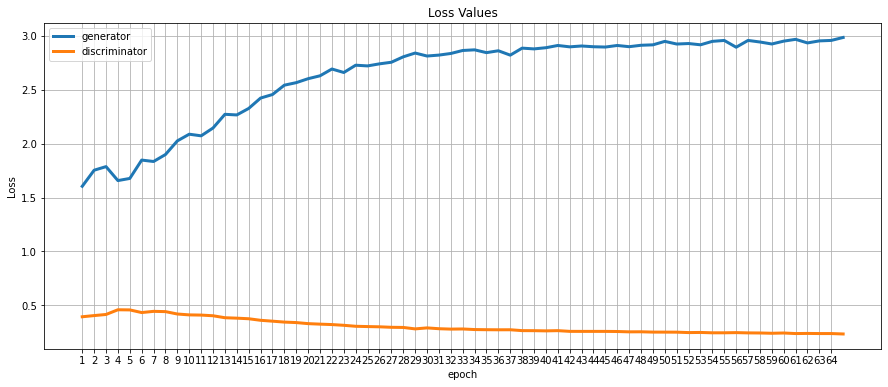

	Epoch: 66, Generator Loss: 2.951179661076139, Discriminator Loss: 0.2355402947693262


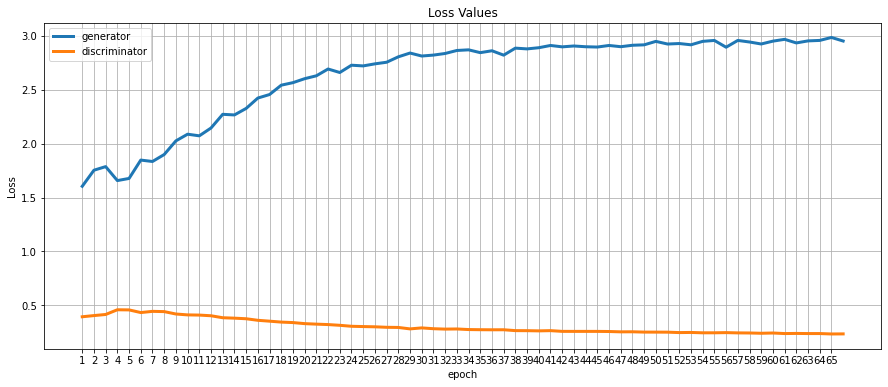

	Epoch: 67, Generator Loss: 2.8173394587830605, Discriminator Loss: 0.23786943853283052


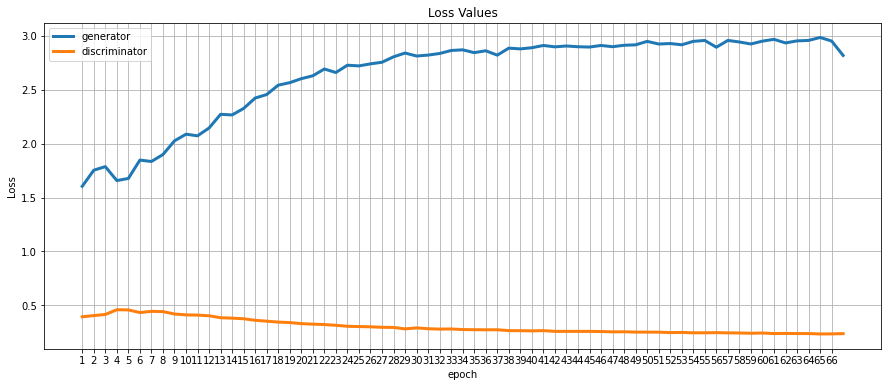

	Epoch: 68, Generator Loss: 2.8912154823808756, Discriminator Loss: 0.23987369317556617


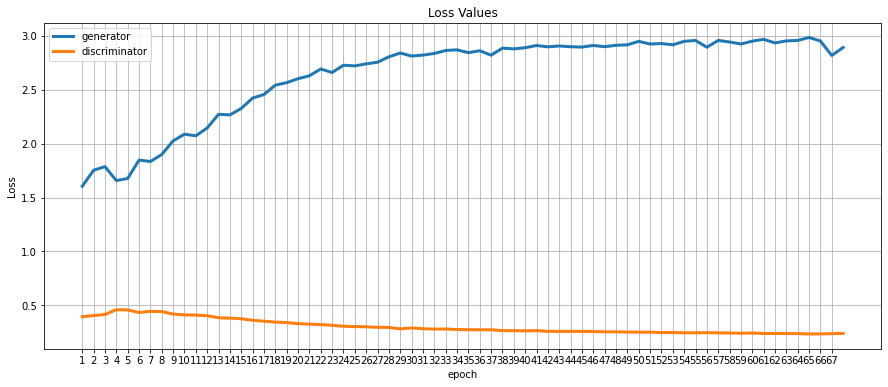

	Epoch: 69, Generator Loss: 2.8846970452007654, Discriminator Loss: 0.23675296798100393


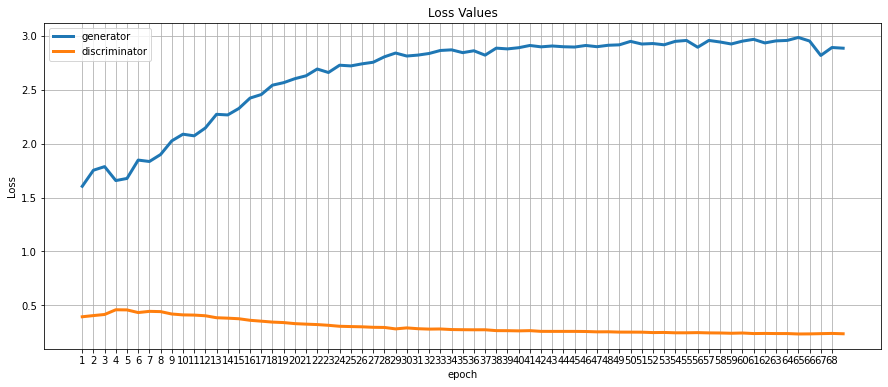

	Epoch: 70, Generator Loss: 2.853027883511652, Discriminator Loss: 0.2400757109462528


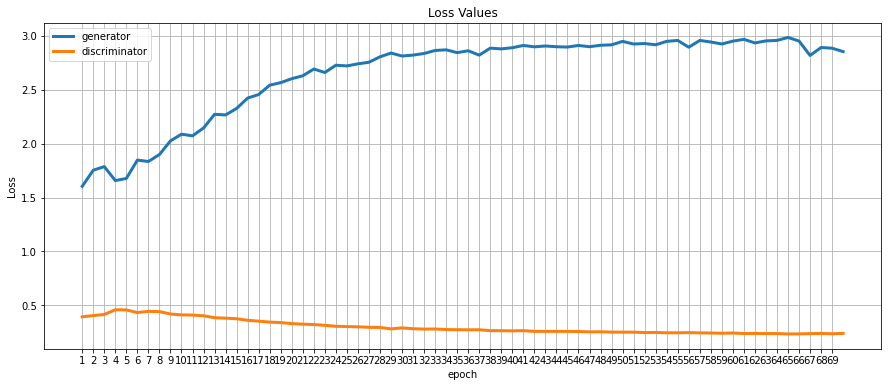

	Epoch: 71, Generator Loss: 2.808888620206855, Discriminator Loss: 0.23739231319647286


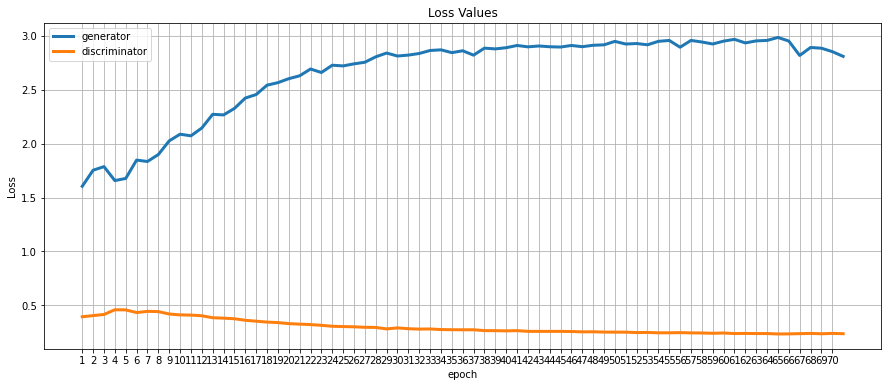

	Epoch: 72, Generator Loss: 2.8114398334952844, Discriminator Loss: 0.2393250605818862


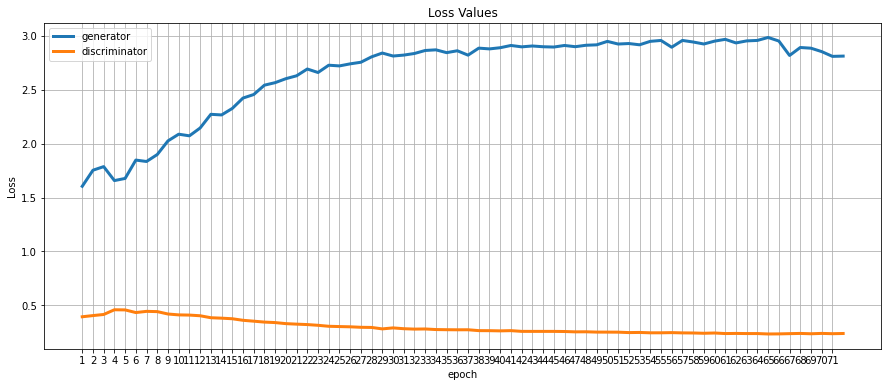

	Epoch: 73, Generator Loss: 2.840869777600988, Discriminator Loss: 0.23968273363101192


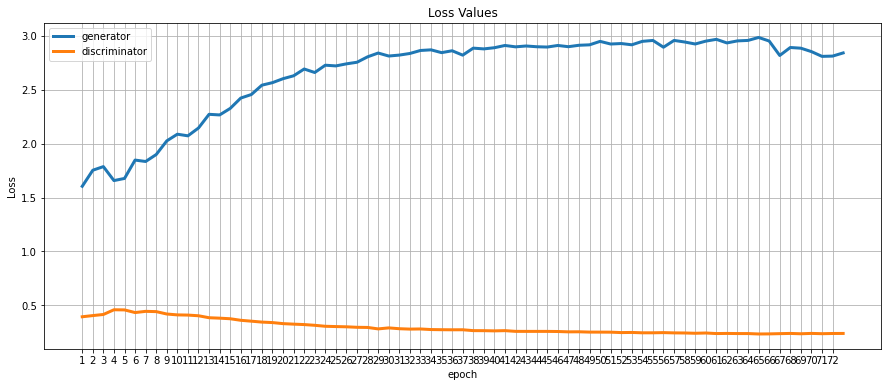

	Epoch: 74, Generator Loss: 2.8171091451382364, Discriminator Loss: 0.23879606317771687


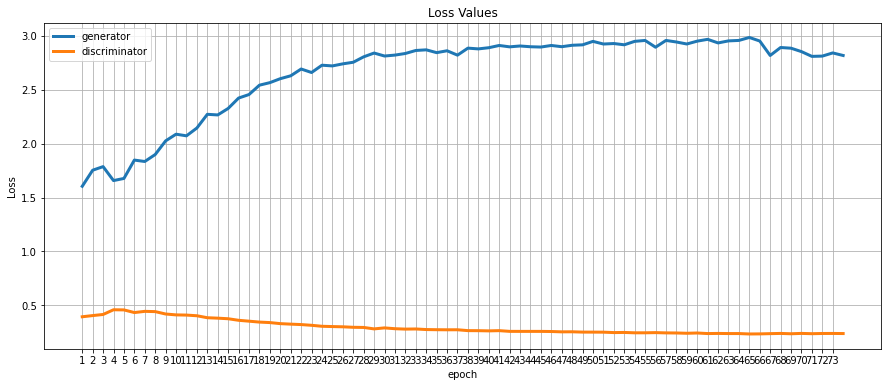

	Epoch: 75, Generator Loss: 2.831583728672753, Discriminator Loss: 0.2335940860450344


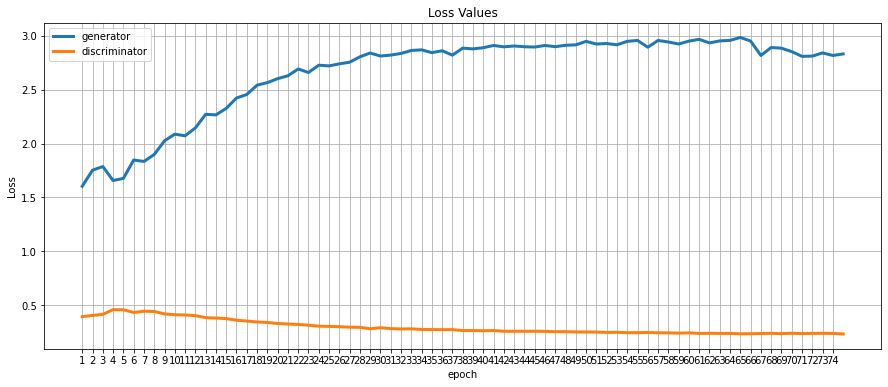

	Epoch: 76, Generator Loss: 2.9120567031920186, Discriminator Loss: 0.20715439487511003


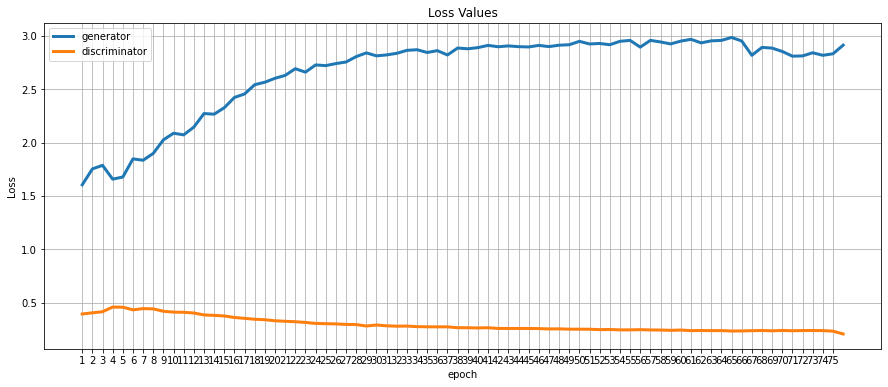

	Epoch: 77, Generator Loss: 2.7949996198528706, Discriminator Loss: 0.20959857545039412


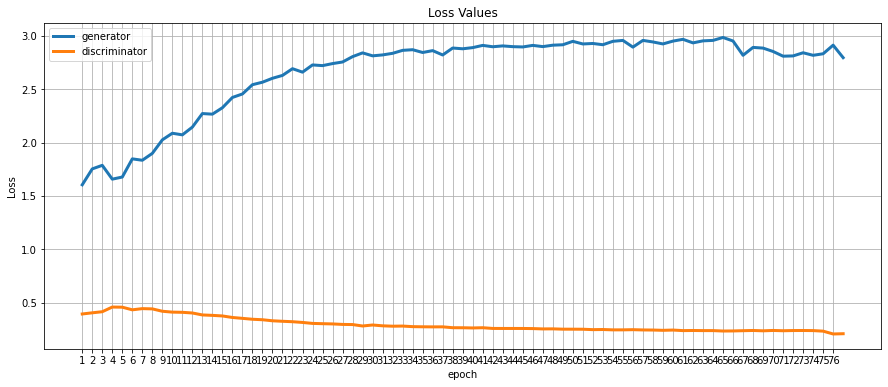

	Epoch: 78, Generator Loss: 2.909073381919638, Discriminator Loss: 0.21489388323013364


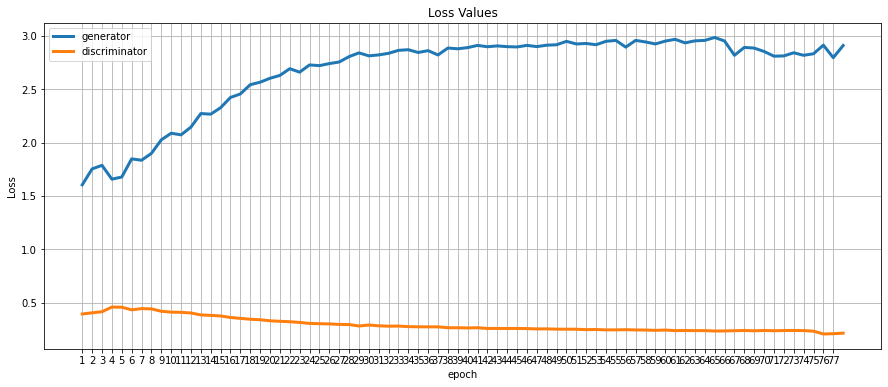

	Epoch: 79, Generator Loss: 2.9995697861139052, Discriminator Loss: 0.20693592652773887


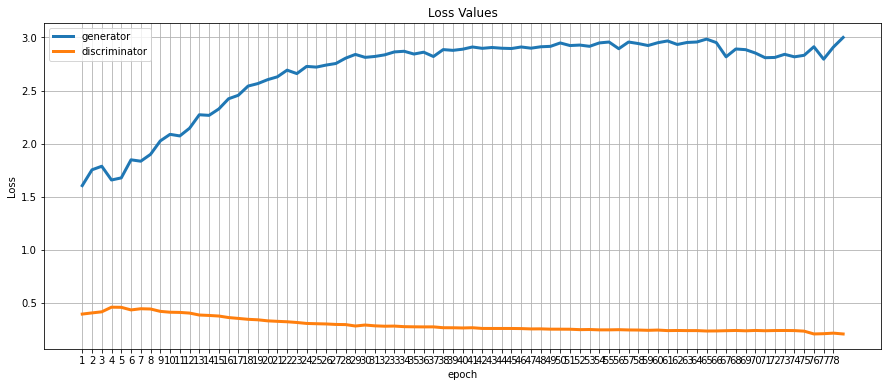

	Epoch: 80, Generator Loss: 2.866147091919878, Discriminator Loss: 0.22831989830495758


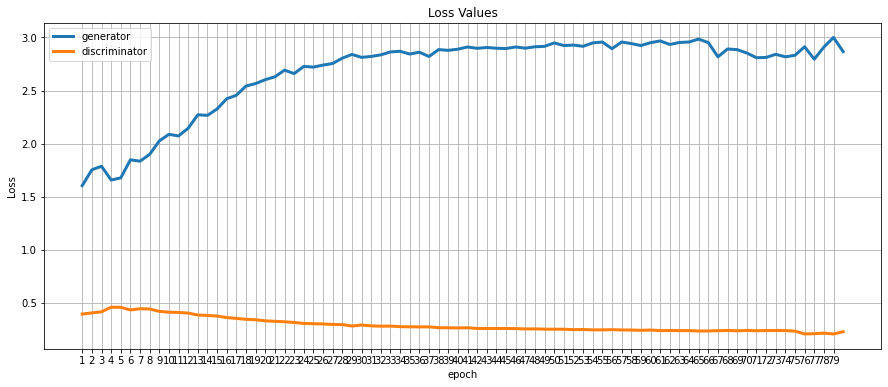

	Epoch: 81, Generator Loss: 2.940687322815005, Discriminator Loss: 0.22922923226057337


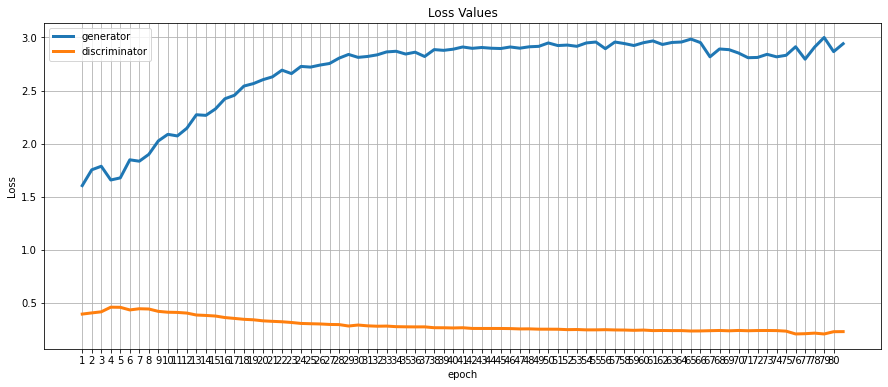

	Epoch: 82, Generator Loss: 2.98234780016385, Discriminator Loss: 0.21556823964918775


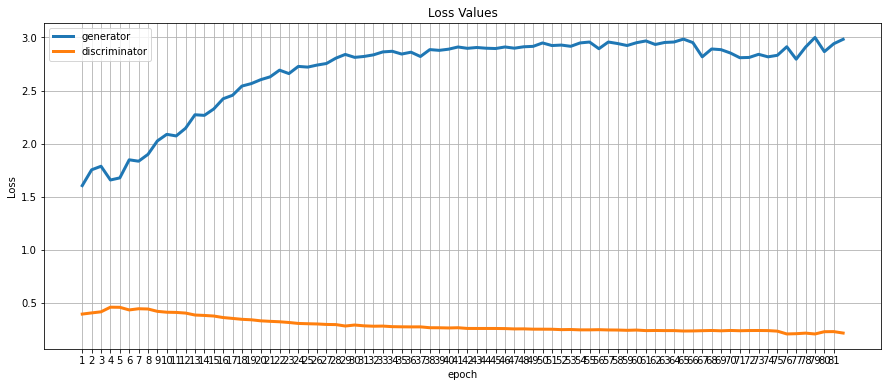

	Epoch: 83, Generator Loss: 2.967803633548844, Discriminator Loss: 0.22308578198148407


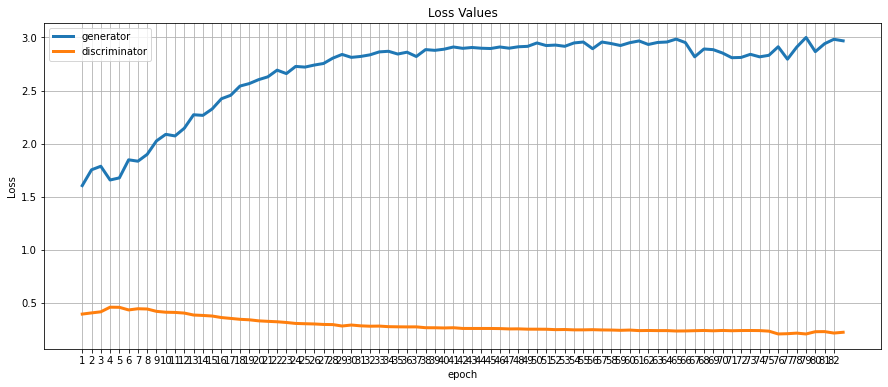

	Epoch: 84, Generator Loss: 2.9769198524356653, Discriminator Loss: 0.21044804649987997


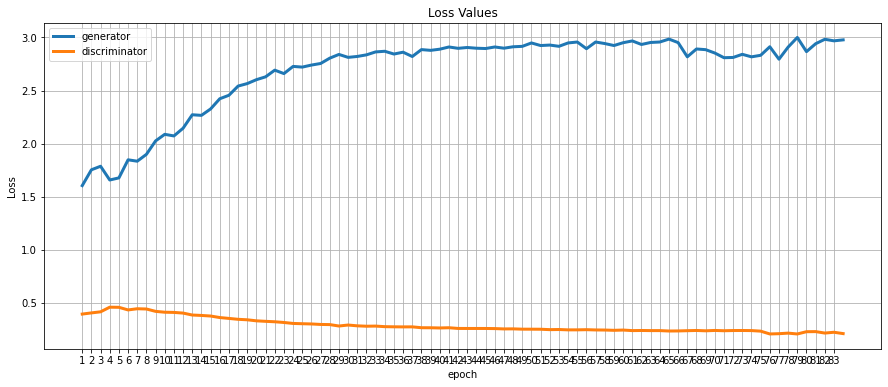

	Epoch: 85, Generator Loss: 3.0201552984198594, Discriminator Loss: 0.20556415943726994


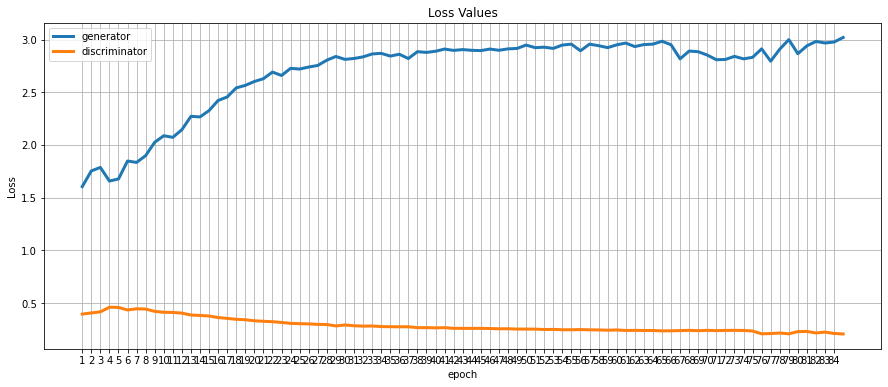

	Epoch: 86, Generator Loss: 2.9982554689526713, Discriminator Loss: 0.20229770401528488


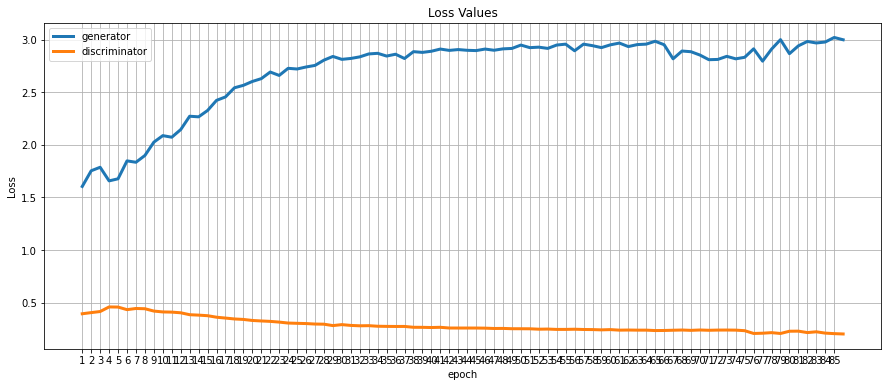

	Epoch: 87, Generator Loss: 2.982948323904934, Discriminator Loss: 0.21287216206060938


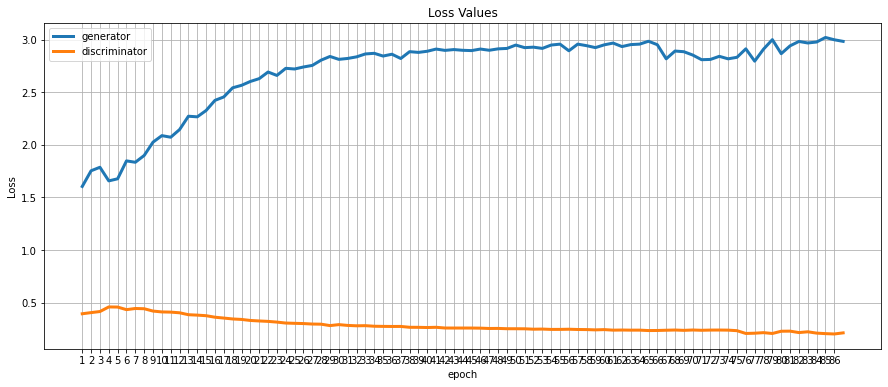

	Epoch: 88, Generator Loss: 2.7196759799836387, Discriminator Loss: 0.2621176862533511


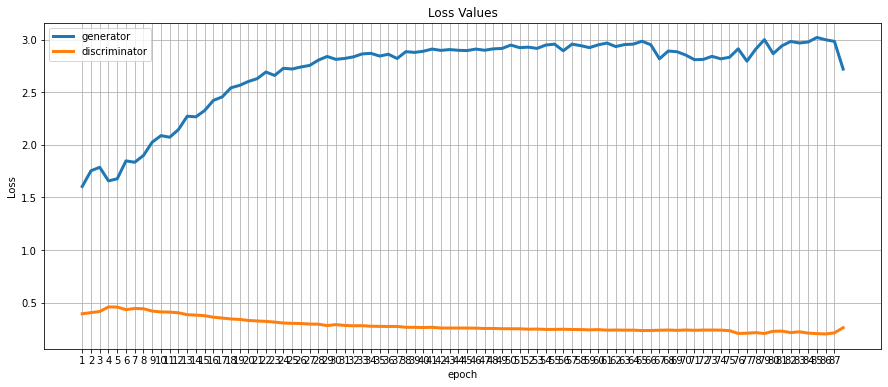

	Epoch: 89, Generator Loss: 2.7862714053192454, Discriminator Loss: 0.24441674851577505


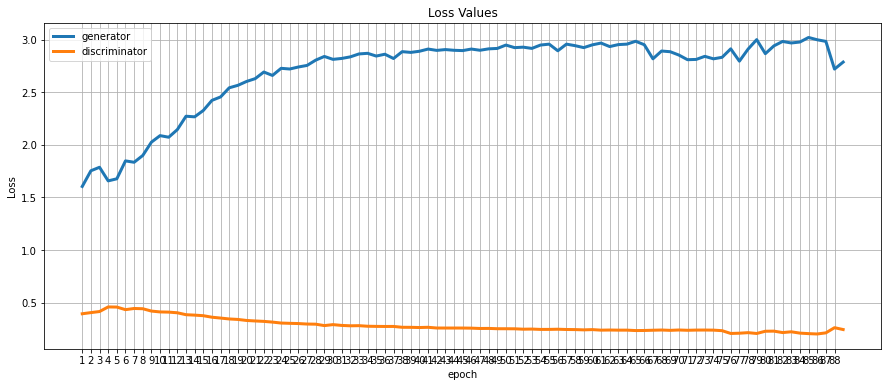

	Epoch: 90, Generator Loss: 2.884332626600119, Discriminator Loss: 0.2377101492790193


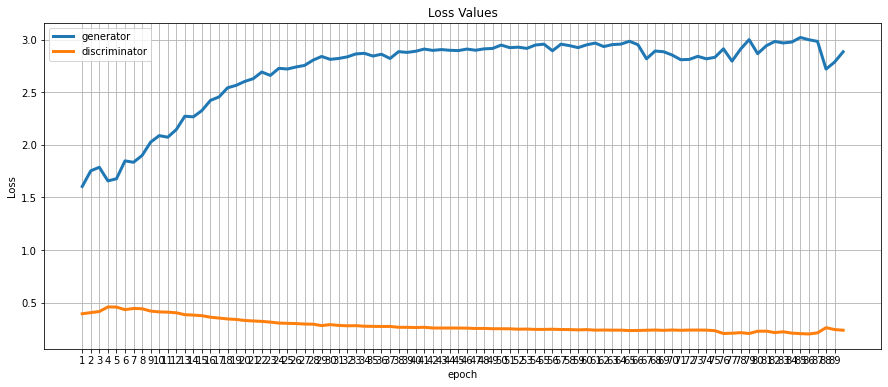

	Epoch: 91, Generator Loss: 2.9551994638009504, Discriminator Loss: 0.20823610821087749


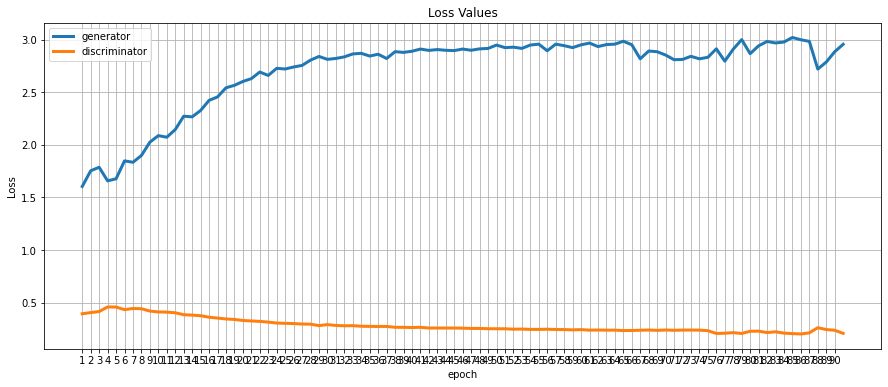

	Epoch: 92, Generator Loss: 2.993765326529245, Discriminator Loss: 0.2093691074893966


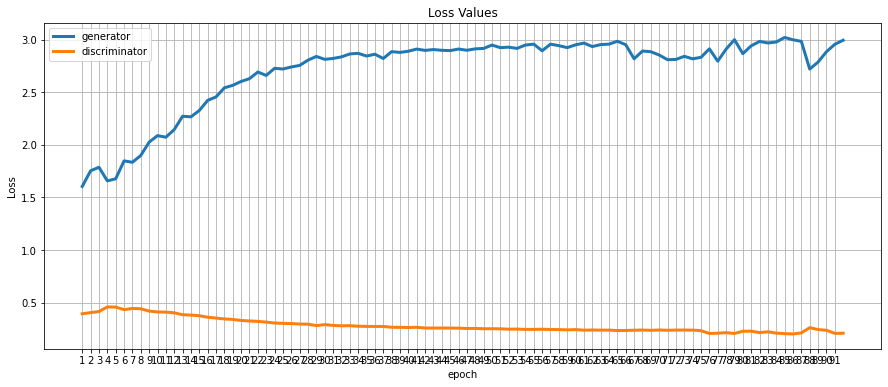

	Epoch: 93, Generator Loss: 2.6888951518204394, Discriminator Loss: 0.26659290738661373


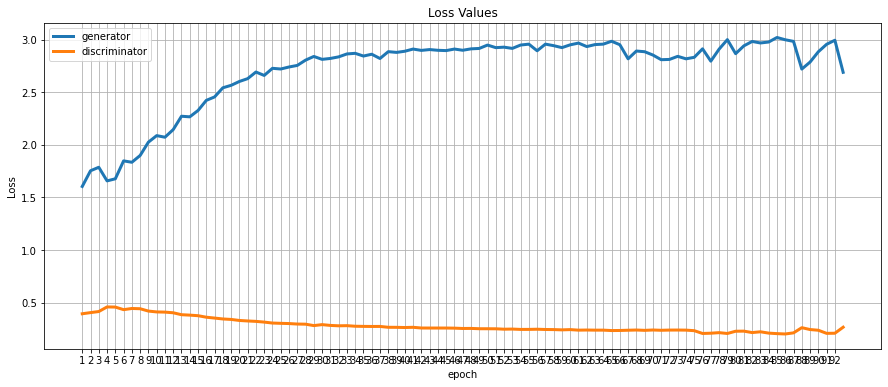

	Epoch: 94, Generator Loss: 2.661352263942418, Discriminator Loss: 0.27378429066051135


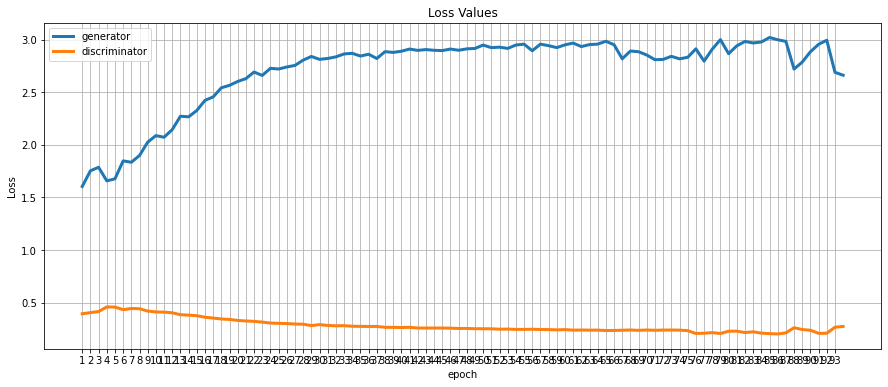

	Epoch: 95, Generator Loss: 2.754899464499935, Discriminator Loss: 0.2570162100309599


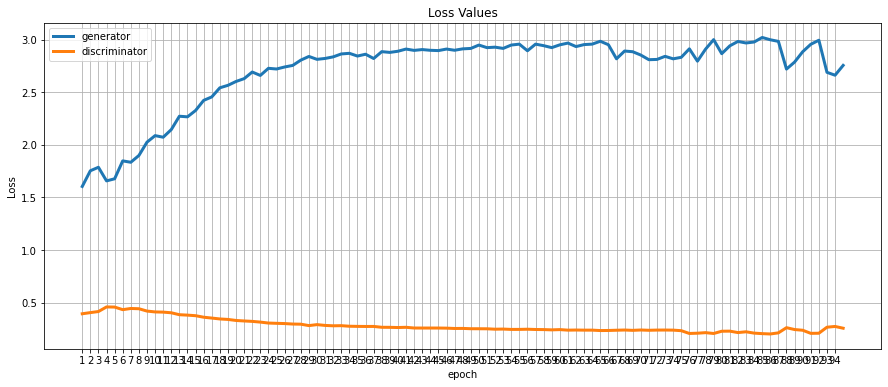

	Epoch: 96, Generator Loss: 2.7795148833574923, Discriminator Loss: 0.2644332514529649


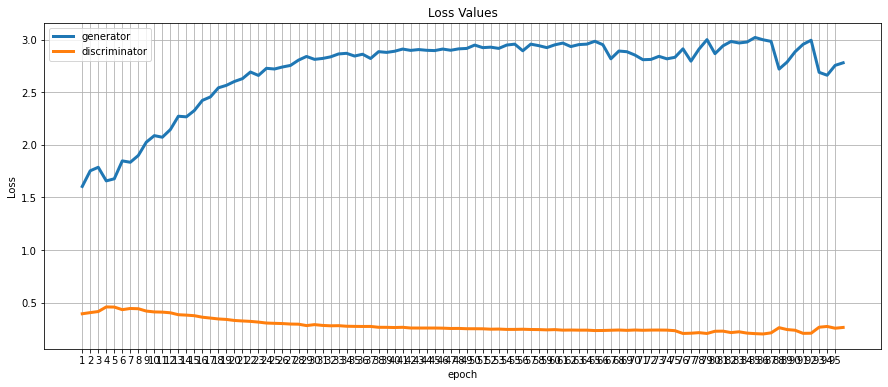

	Epoch: 97, Generator Loss: 2.7145216964309253, Discriminator Loss: 0.25935781872074065


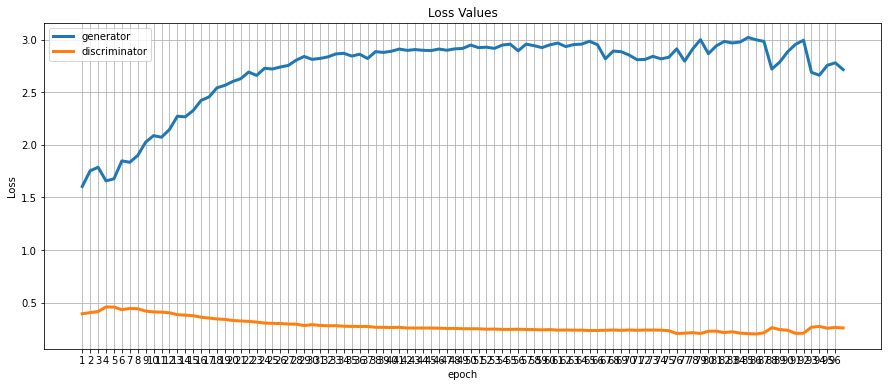

	Epoch: 98, Generator Loss: 2.73761649950671, Discriminator Loss: 0.2530299539602673


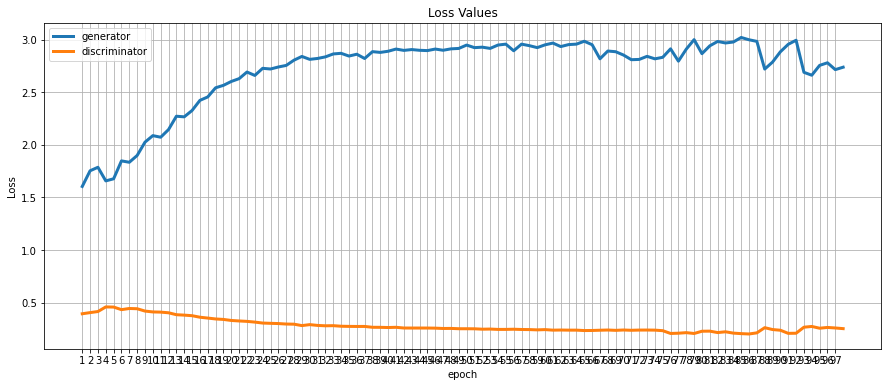

	Epoch: 99, Generator Loss: 2.9002630068382746, Discriminator Loss: 0.21874200916168174


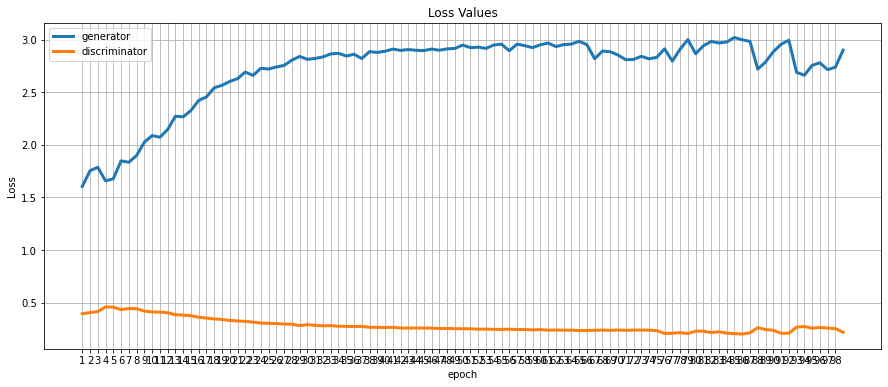

	Epoch: 100, Generator Loss: 2.9981375627420013, Discriminator Loss: 0.20009897307763486


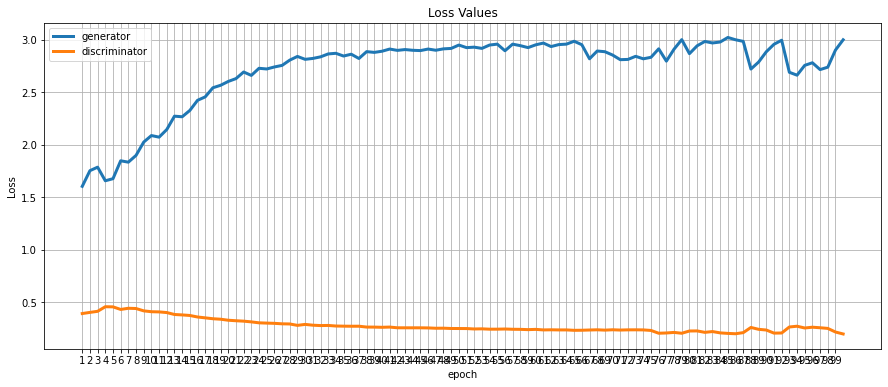

In [ ]:
# Array to store samples for experience replay
exp_replay = []
g_loss_hist = []
d_loss_hist = []

N_EPOCHS = 100
for epoch in range(N_EPOCHS):

  cum_d_loss = 0.
  cum_g_loss = 0.
  
  for batch_idx in range(num_batches):
    # Prepare real images and their lables as input of our GAN
    images = X_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]
    labels = y_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]

    noise_data = generate_noise(BATCH_SIZE, 100)
    random_labels = generate_random_labels(BATCH_SIZE)
    # Genarate Fake images
    generated_images = generator.predict([noise_data, labels])

    # Train on soft targets
    noise_prop = 0.05 # Randomly flip 5% of targets
    
    # Prepare labels for real data
    true_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
    true_labels[flipped_idx] = 1 - true_labels[flipped_idx]
    
    # Train discriminator on real data
    d_loss_true = discriminator.train_on_batch([images, labels], true_labels)

    # Generated images labels
    gene_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
    flipped_idx = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop*len(gene_labels)))
    gene_labels[flipped_idx] = 1 - gene_labels[flipped_idx]
    
    # Train discriminator on generated data
    d_loss_gene = discriminator.train_on_batch([generated_images, labels], gene_labels)
    
    # Store a random point for experience replay (For mode-colaps avoiding)
    r_idx = np.random.randint(BATCH_SIZE)
    exp_replay.append([generated_images[r_idx], labels[r_idx], gene_labels[r_idx]])
    
    # If we have enough points, do experience replay
    if len(exp_replay) == BATCH_SIZE:
      generated_images = np.array([p[0] for p in exp_replay])
      labels = np.array([p[1] for p in exp_replay])
      gene_labels = np.array([p[2] for p in exp_replay])
      expprep_loss_gene = discriminator.train_on_batch([generated_images, labels], gene_labels)
      exp_replay = []
    
    d_loss = 0.5 * np.add(d_loss_true, d_loss_gene)
    cum_d_loss += d_loss

    # Train generator
    noise_data = generate_noise(BATCH_SIZE, 100)
    random_labels = generate_random_labels(BATCH_SIZE)
    g_loss = gan.train_on_batch([noise_data, random_labels, random_labels], np.zeros((BATCH_SIZE, 1)))
    cum_g_loss += g_loss
  g_loss_tmp = cum_g_loss/num_batches
  d_loss_tmp = cum_d_loss[0]/num_batches
  g_loss_hist.append(g_loss_tmp)
  d_loss_hist.append(d_loss_tmp)
  print('\tEpoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch+1, g_loss_tmp, d_loss_tmp))
  show_samples(epoch+1)
  plot_diagram(g_loss_hist, d_loss_hist, epoch)

**Train GAN in a two step manner. First train discriminator with real and fake images respectively. Then freez discriminator and train genrator**